## Load Essential Libraries

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pooria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Pooria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pooria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load Data

In [214]:
file_path = 'data/Animation_Movies.csv'
df = pd.read_csv(file_path)
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,150540,Inside Out,7.922,19463,Released,2015-06-09,857611174,95,False,/j29ekbcLpBvxnGk6LjdTc2EI5SA.jpg,...,en,Inside Out,"Growing up can be a bumpy road, and it's no ex...",107.292,/2H1TmgdfNtsKlU9jKdeNyYL5y8T.jpg,Meet the little voices inside your head.,"Animation, Family, Adventure, Drama, Comedy","Pixar, Walt Disney Pictures",United States of America,English
1,14160,Up,7.949,18857,Released,2009-05-28,735099082,96,False,/hGGC9gKo7CFE3fW07RA587e5kol.jpg,...,en,Up,Carl Fredricksen spent his entire life dreamin...,90.968,/vpbaStTMt8qqXaEgnOR2EE4DNJk.jpg,The greatest adventure is just getting back home.,"Animation, Comedy, Family, Adventure",Pixar,United States of America,English
2,12,Finding Nemo,7.824,18061,Released,2003-05-30,940335536,100,False,/h3uqFk7sZRJvLZDdLiFB9qwbL07.jpg,...,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",55.456,/ggQ6o8X5984OCh3kZi2UIJQJY5y.jpg,There are 3.7 trillion fish in the ocean. They...,"Animation, Family",Pixar,United States of America,English
3,354912,Coco,8.222,17742,Released,2017-10-27,800526015,105,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,...,en,Coco,Despite his family’s baffling generations-old ...,166.578,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,The celebration of a lifetime,"Family, Animation, Fantasy, Music, Comedy, Adv...","Pixar, Walt Disney Pictures",United States of America,"English, Spanish"
4,10681,WALL·E,8.078,17446,Released,2008-06-22,521311860,98,False,/fK5ssgvtI43z19FoWigdlqgpLRE.jpg,...,en,WALL·E,What if mankind had to leave Earth and somebod...,58.517,/hbhFnRzzg6ZDmm8YAmxBnQpQIPh.jpg,After 700 years of doing what he was built for...,"Animation, Family, Science Fiction","Pixar, Walt Disney Pictures",United States of America,English


# Part 1: Data Recognition

## structure of data

In [215]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51945 entries, 0 to 51944
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    51945 non-null  int64  
 1   title                 51944 non-null  object 
 2   vote_average          51945 non-null  float64
 3   vote_count            51945 non-null  int64  
 4   status                51945 non-null  object 
 5   release_date          49808 non-null  object 
 6   revenue               51945 non-null  int64  
 7   runtime               51945 non-null  int64  
 8   adult                 51945 non-null  bool   
 9   backdrop_path         15835 non-null  object 
 10  budget                51945 non-null  int64  
 11  homepage              8253 non-null   object 
 12  imdb_id               29552 non-null  object 
 13  original_language     51945 non-null  object 
 14  original_title        51944 non-null  object 
 15  overview           

,id,vote_average,vote_count,revenue,runtime,budget,popularity
count,5.194500e+04,51945.000000,51945.000000,5.194500e+04,51945.000000,5.194500e+04,51945.000000
mean,6.188122e+05,2.597083,40.395380,1.863464e+06,20.901415,5.759513e+05,1.886233
std,3.479748e+05,3.318748,482.705948,3.049824e+07,39.016002,7.606628e+06,9.700913
min,1.200000e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.300810e+05,0.000000,0.000000,0.000000e+00,3.000000,0.000000e+00,0.600000
50%,6.119150e+05,0.000000,0.000000,0.000000e+00,7.000000,0.000000e+00,0.600000
75%,9.159040e+05,6.000000,2.000000,0.000000e+00,19.000000,0.000000e+00,0.882000
max,1.238314e+06,10.000000,19463.000000,1.450027e+09,3720.000000,2.600000e+08,1008.942000


### Calculating Statistical Metrics for Each Numeric Column

In [216]:
def calculate_statistics(data_frame, Numeric_Features):
    stats__summary = []

    for feature in Numeric_Features:
        dtype = data_frame[feature].dtype
        min_value = data_frame[feature].min()
        max_value = data_frame[feature].max()
        mean_value = data_frame[feature].mean()
        median_value = data_frame[feature].median()
        mode_value = data_frame[feature].mode()[0]  # First mode in case there are multiple modes
        value_range = f"{min_value} - {max_value}"

        # Add the calculated statistics to the summary DataFrame
        stats__summary.append({
            'Feature': feature,
            'Type': dtype,
            'Min': min_value,
            'Max': max_value,
            'Mean': mean_value,
            'Median': median_value,
            'Mode': mode_value,
            'Range': value_range
        })

    # Convert list to DataFrame
    stats_summary_df = pd.DataFrame(stats__summary)

    return stats_summary_df


# List of numerical features for analysis
numeric_features = ['vote_average', 'vote_count', 'runtime', 'revenue', 'budget', 'popularity']
stats_summary = calculate_statistics(df, numeric_features)

# Display the statistical summary table
stats_summary

,Feature,Type,Min,Max,Mean,Median,Mode,Range
0,vote_average,float64,0.0,1.000000e+01,2.597083e+00,0.0,0.0,0.0 - 10.0
1,vote_count,int64,0.0,1.946300e+04,4.039538e+01,0.0,0.0,0 - 19463
2,runtime,int64,0.0,3.720000e+03,2.090141e+01,7.0,0.0,0 - 3720
3,revenue,int64,0.0,1.450027e+09,1.863464e+06,0.0,0.0,0 - 1450026933
4,budget,int64,0.0,2.600000e+08,5.759513e+05,0.0,0.0,0 - 260000000
5,popularity,float64,0.0,1.008942e+03,1.886233e+00,0.6,0.6,0.0 - 1008.942


### Detecting Outliers

In [217]:
def detect_outliers(data_frame, Numeric_Features):
    outliers_list = []

    for feature in Numeric_Features:
        Q1 = data_frame[feature].quantile(0.25)
        Q3 = data_frame[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data_frame[(data_frame[feature] < (Q1 - 1.5 * IQR)) | (data_frame[feature] > (Q3 + 1.5 * IQR))][
            feature].values

        # Calculate the percentage of outliers
        total_data_points = len(data_frame[feature])
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / total_data_points) * 100

        # Append a dictionary to the list
        outliers_list.append({
            'Feature': feature,
            'Outliers': outliers,
            'Outlier_Percentage': outlier_percentage
        })

    # Create the summary DataFrame once at the end
    outliers__summary = pd.DataFrame(outliers_list)

    return outliers__summary


# Use the modified function
outliers_summary = detect_outliers(df, numeric_features)

# Display the outliers summary table
outliers_summary

,Feature,Outliers,Outlier_Percentage
0,vote_average,[],0.000000
1,vote_count,"[19463, 18857, 18061, 17742, 17446, 17189, 171...",16.170950
2,runtime,"[95, 96, 100, 105, 98, 92, 81, 89, 115, 90, 11...",17.510829
3,revenue,"[857611174, 735099082, 940335536, 800526015, 5...",2.117624
4,budget,"[175000000, 175000000, 94000000, 175000000, 18...",3.085956
5,popularity,"[107.292, 90.968, 55.456, 166.578, 58.517, 86....",19.720859


### Creating a Data Recognition Table

In [218]:
def summarize_data(data_frame, Numeric_Features):
    stats__summary = calculate_statistics(data_frame, Numeric_Features)
    outliers__summary = detect_outliers(data_frame, Numeric_Features)

    # Merge statistics and outliers data
    final__summary = stats__summary.merge(outliers__summary, on='Feature', how='left')
    return final__summary


# Generate the final summary
final_summary = summarize_data(df, numeric_features)

# Display the final summary
final_summary

,Feature,Type,Min,Max,Mean,Median,Mode,Range,Outliers,Outlier_Percentage
0,vote_average,float64,0.0,1.000000e+01,2.597083e+00,0.0,0.0,0.0 - 10.0,[],0.000000
1,vote_count,int64,0.0,1.946300e+04,4.039538e+01,0.0,0.0,0 - 19463,"[19463, 18857, 18061, 17742, 17446, 17189, 171...",16.170950
2,runtime,int64,0.0,3.720000e+03,2.090141e+01,7.0,0.0,0 - 3720,"[95, 96, 100, 105, 98, 92, 81, 89, 115, 90, 11...",17.510829
3,revenue,int64,0.0,1.450027e+09,1.863464e+06,0.0,0.0,0 - 1450026933,"[857611174, 735099082, 940335536, 800526015, 5...",2.117624
4,budget,int64,0.0,2.600000e+08,5.759513e+05,0.0,0.0,0 - 260000000,"[175000000, 175000000, 94000000, 175000000, 18...",3.085956
5,popularity,float64,0.0,1.008942e+03,1.886233e+00,0.6,0.6,0.0 - 1008.942,"[107.292, 90.968, 55.456, 166.578, 58.517, 86....",19.720859


### Creating a Boxplot for Numerical Data

In [219]:
def plot_boxplots(data_frame, columns, exclude_zero_columns=None, after_preprocessing=False, figsize=(20, 12),
                  linewidth=1.5):
    if exclude_zero_columns is None:
        exclude_zero_columns = []

    # Determine the number of rows and columns for subplots
    num_plots = len(columns)
    rows = (num_plots + 2) // 3  # Round up to the nearest integer
    cols = 3  # Number of columns

    # Set up the subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over

    # Create box-plots for each column
    for i, column in enumerate(columns):
        # Determine the scale of the data for scientific notation
        max_abs_value = data_frame[column].abs().max()
        if max_abs_value != 0:
            exponent = int(np.floor(np.log10(max_abs_value)))
            scale_notation = f'1e{exponent}'
        else:
            scale_notation = '1e0'

        # Apply filters if after_preprocessing is True and if the column is 'runtime'
        if after_preprocessing and column == 'runtime':
            # Filter data to only show points outside the range [10, 90] as potential outliers
            filtered_data = data_frame[(data_frame[column] < 10) | (data_frame[column] > 90)][column]
            sns.boxplot(y=filtered_data, ax=axes[i], linewidth=linewidth, color='cyan')
            axes[i].set_title(f'Boxplot of {column} (Filtered)\nScale: {scale_notation}', fontsize=14)
        else:
            if column in exclude_zero_columns:
                # Separate non-zero data and consider zeros as outliers
                non_zero_data = data_frame[data_frame[column] != 0][column]
                zero_outliers = data_frame[data_frame[column] == 0][column]

                # Plot the box plot for non-zero data
                sns.boxplot(y=non_zero_data, ax=axes[i], linewidth=linewidth, color='cyan')

                # Plot zero values as outliers (by scattering them over the plot)
                axes[i].scatter([0] * len(zero_outliers), zero_outliers, color='red', label='Zero Outliers', marker='x',
                                zorder=5)

                # Add a legend for outliers
                axes[i].legend()
            else:
                # Use the original data for this column
                sns.boxplot(data=data_frame, y=column, ax=axes[i], linewidth=linewidth, color='cyan')

            # Add the title with the scale notation
            axes[i].set_title(f'Boxplot of {column}\nScale: {scale_notation}', fontsize=14)

        axes[i].set_ylabel('Values', fontsize=12)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

    # Hide unused subplots if any
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout for better spacing
    plt.tight_layout()
    plt.show()

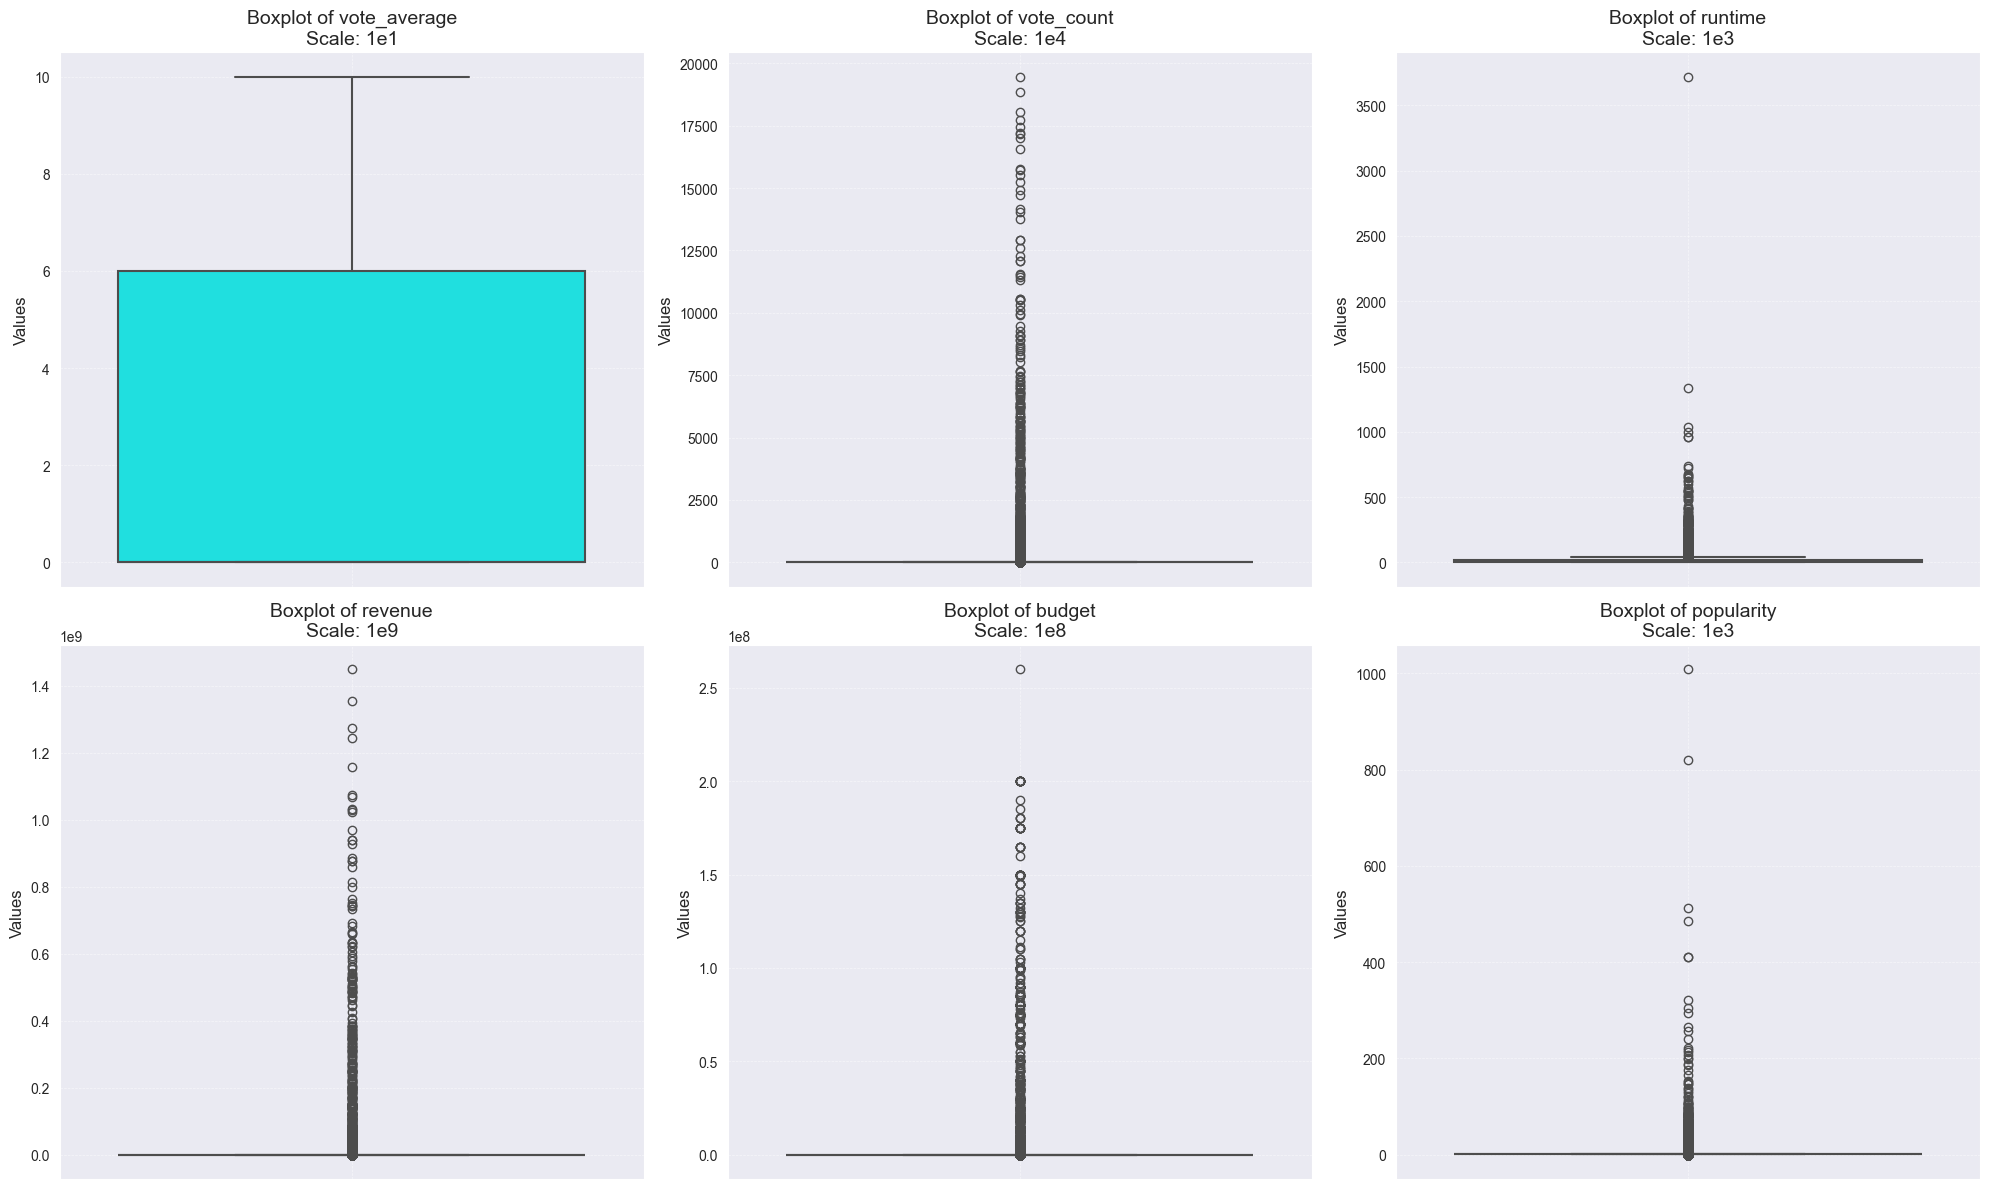

In [220]:
plot_boxplots(df, numeric_features)

# Part2 : Data Quality Assessment

In [221]:
def data_quality_assessment(df, excluded_columns):
    # Filter columns to be analyzed
    columns_to_analyze = [col for col in df.columns if col not in excluded_columns]

    # Consistency Check
    def check_consistency(data_frame, column):
        if column == 'release_date':
            invalid_dates = data_frame[pd.to_datetime(data_frame[column], errors='coerce').isna()]
            return len(invalid_dates)
        elif column == 'original_language':
            invalid_languages = data_frame[~data_frame[column].str.match(r'^[a-z]{2}$', na=False)]
            return len(invalid_languages)
        elif column == 'status':
            valid_statuses = ['Released', 'In Production', 'Canceled', 'Planned', 'Post Production', 'Rumored']
            invalid_status = data_frame[~data_frame[column].isin(valid_statuses)]
            return len(invalid_status)
        elif column == 'adult':
            valid_adult_values = ['True', 'False']
            invalid_adult = data_frame[~data_frame[column].isin(valid_adult_values)]
            return len(invalid_adult)
        elif column in ['genres', 'production_companies', 'production_countries', 'spoken_languages']:
            invalid_entries = data_frame[column][
                data_frame[column].apply(lambda x: isinstance(x, str) and ',' not in x)]
            return len(invalid_entries)
        else:
            return 'N/A'

    # Currentness Check
    def check_currentness(data_frame, column):
        current_year = datetime.now().year
        if column == 'release_date':
            data_frame['Year'] = pd.to_datetime(data_frame[column], errors='coerce').dt.year
            recent_data = data_frame[data_frame['Year'] >= current_year - 10]
            return len(recent_data)
        elif column == 'status':
            mismatched_status = data_frame[
                ((data_frame['status'] == 'Released') & (
                        pd.to_datetime(data_frame['release_date'], errors='coerce') > datetime.now())) |
                ((data_frame['status'] == 'In Production') & (
                        pd.to_datetime(data_frame['release_date'], errors='coerce') <= datetime.now()))
                ]
            return len(mismatched_status)
        elif column == 'popularity':
            recent_popularity = data_frame[
                (pd.to_datetime(data_frame['release_date'], errors='coerce').dt.year >= current_year - 5) & (
                        data_frame[column] > 0)]
            return len(recent_popularity)
        else:
            return 'N/A'

    # Validity Check
    def check_validity(data_frame, column):
        if column == 'id':
            unique_ids = data_frame['id'].nunique()
            total_records = len(data_frame)
            return total_records - unique_ids
        elif column == 'vote_average':
            invalid_values = data_frame[~data_frame[column].between(0, 10)]
            return len(invalid_values)
        elif column == 'vote_count':
            invalid_values = data_frame[~data_frame[column].apply(lambda x: isinstance(x, int) and x >= 0)]
            return len(invalid_values)
        elif column in ['revenue', 'budget']:
            invalid_values = data_frame[data_frame[column] < 0]
            unreasonable_values = data_frame[data_frame[column] > 1e9]
            return len(invalid_values) + len(unreasonable_values)
        elif column == 'runtime':
            invalid_values = data_frame[(data_frame[column] <= 0) | (data_frame[column] > 300)]
            return len(invalid_values)
        elif column == 'imdb_id':
            invalid_imdb_ids = data_frame[~data_frame[column].str.match(r'^tt\d{7,8}$', na=False)]
            return len(invalid_imdb_ids)
        elif column in ['genres', 'production_companies', 'production_countries', 'spoken_languages']:
            invalid_entries = data_frame[column][
                data_frame[column].apply(lambda x: isinstance(x, str) and ',' not in x)]
            return len(invalid_entries)
        elif column in ['overview', 'tagline']:
            invalid_texts = data_frame[column][
                data_frame[column].str.contains(r'[^\w\s,.!?\'\"-]', regex=True, na=False)]
            return len(invalid_texts)
        else:
            return 'N/A'

    # Completeness Check
    def check_completeness(data_frame, column):
        essential_columns = [
            'id', 'title', 'release_date', 'status', 'vote_count', 'vote_average',
            'popularity', 'budget', 'revenue', 'imdb_id', 'overview', 'genres',
            'production_companies', 'production_countries'
        ]
        if column in essential_columns:
            null_count = data_frame[column].isnull().sum()
            return null_count
        else:
            return 0  # For non-essential columns, assume completeness is not an issue

    # Accuracy Check (now simplified to check data availability)
    def check_accuracy(data_frame, column):
        non_null_count = data_frame[column].notnull().sum()
        accuracy = (non_null_count / len(data_frame)) * 100  # Percentage of non-null values
        return f"{accuracy:.2f}%"

    # Generate the table
    data_quality_table = []

    for column in columns_to_analyze:
        record_count = len(df)
        null_count = check_completeness(df, column)
        consistency_issues = check_consistency(df, column)
        currentness_count = check_currentness(df, column)
        validity_issues = check_validity(df, column)
        accuracy = check_accuracy(df, column)

        data_quality_table.append({
            'Feature Name': column,
            'Number of Records': record_count,
            'Number of Nulls': null_count,
            'Accuracy (%)': accuracy,
            'Completeness': null_count == 0,
            'Validity Issues': validity_issues,
            'Currentness Count': currentness_count,
            'Consistency Issues': consistency_issues
        })

    # Create DataFrame for better visualization
    quality_df = pd.DataFrame(data_quality_table)
    return quality_df


In [222]:
# Call the function and pass the DataFrame and excluded columns
excluded_columns = ['backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'tagline']
quality_df = data_quality_assessment(df, excluded_columns)

# Display the result
quality_df

# Save the table as a CSV for reporting purposes (optional)
# quality_df.to_csv('/mnt/data/data_quality_report.csv', index=False)

,Feature Name,Number of Records,Number of Nulls,Accuracy (%),Completeness,Validity Issues,Currentness Count,Consistency Issues
0,id,51945,0,100.00%,True,0,N/A,N/A
1,title,51945,1,100.00%,False,N/A,N/A,N/A
2,vote_average,51945,0,100.00%,True,0,N/A,N/A
3,vote_count,51945,0,100.00%,True,0,N/A,N/A
4,status,51945,0,100.00%,True,N/A,101,0
5,release_date,51945,2137,95.89%,False,N/A,18676,2137
6,revenue,51945,0,100.00%,True,10,N/A,N/A
7,runtime,51945,0,100.00%,True,6362,N/A,N/A
8,adult,51945,0,100.00%,True,N/A,N/A,51945
9,budget,51945,0,100.00%,True,0,N/A,N/A


# Part 3: Data Preparation

In [223]:
df.isnull().sum()

id                          0
title                       1
vote_average                0
vote_count                  0
status                      0
release_date             2137
revenue                     0
runtime                     0
adult                       0
backdrop_path           36110
budget                      0
homepage                43692
imdb_id                 22393
original_language           0
original_title              1
overview                 6079
popularity                  0
poster_path             14011
tagline                 47267
genres                      0
production_companies    22547
production_countries    12245
spoken_languages        18127
Year                     2137
dtype: int64

### Drop unused columns from the DataFrame.

In [224]:
unused_columns = ['backdrop_path', 'homepage', 'imdb_id', 'poster_path', 'tagline']
df.drop(columns=unused_columns, axis=1, inplace=True)

###  Handling Missing, Inconsistent, and Erroneous Data

* #### Replace Blank values

In [225]:
# Replace Blank values with the string 'null'
df[['title', 'original_title', 'overview']] = df[['title', 'original_title', 'overview']].fillna('null')

* #### release_date 

In [226]:
def convert_release_date_to_datetime(data_frame):
    """Convert 'release_date' column to datetime format."""
    data_frame['release_date'] = pd.to_datetime(data_frame['release_date'])
    return data_frame


def get_current_date():
    """Get the current date as a timestamp."""
    return pd.Timestamp.now()


def mark_future_releases(data_frame, current_date):
    """Update records with 'release_date' after the current date."""
    future_df = data_frame[data_frame['release_date'] > current_date]

    # Update the status, vote_average, and vote_count for future records
    data_frame.loc[future_df.index, 'vote_count'] = 0
    data_frame.loc[future_df.index, 'vote_average'] = 0
    data_frame.loc[future_df.index, 'status'] = 'In Production'
    return data_frame


def remove_null_release_dates(data_frame):
    """Remove rows where 'release_date' is null."""
    data_frame.dropna(subset=['release_date'], inplace=True)
    return data_frame


def process_dataframe(data_frame):
    """Main function to execute all data processing steps."""
    data_frame = convert_release_date_to_datetime(data_frame)
    current_date = get_current_date()
    data_frame = mark_future_releases(data_frame, current_date)
    data_frame = remove_null_release_dates(data_frame)
    return data_frame

##### Usage

In [227]:
df = process_dataframe(df)

* #### popularity

In [228]:
# Replace values greater than 100 with 100
df['popularity'] = df['popularity'].clip(upper=100)

* #### Prediction Model for Filling NaN in Language Field

In [229]:
def prepare_data(data_frame):
    """Filter rows where 'spoken_languages' and 'production_countries' are not null."""
    return data_frame[data_frame['spoken_languages'].notna() & data_frame['production_countries'].notna()]


def encode_features_and_target(data):
    """Encode 'production_countries' as features and 'spoken_languages' as target."""
    country_encoder = LabelEncoder()
    language_encoder = LabelEncoder()

    features_encoded = country_encoder.fit_transform(data['production_countries']).reshape(-1, 1)
    target_encoded = language_encoder.fit_transform(data['spoken_languages'])

    return features_encoded, target_encoded, country_encoder, language_encoder


def train_model(features_train, target_train):
    """Train a Decision Tree Classifier and return the model."""
    decision_tree_model = DecisionTreeClassifier()
    decision_tree_model.fit(features_train, target_train)
    return decision_tree_model


def predict_missing_languages(data_frame, Model, country_encoder, language_encoder):
    """Predict and fill missing 'spoken_languages' based on 'production_countries'."""
    rows_to_predict = data_frame[data_frame['spoken_languages'].isna() & data_frame['production_countries'].notna()]

    features_to_predict = []
    for country in rows_to_predict['production_countries']:
        try:
            features_to_predict.append(country_encoder.transform([country])[0])
        except ValueError:
            features_to_predict.append(-1)  # Fallback value for unseen labels

    features_to_predict = np.array(features_to_predict).reshape(-1, 1)
    predicted_encoded = Model.predict(features_to_predict)
    predicted_languages = language_encoder.inverse_transform(predicted_encoded)

    data_frame.loc[data_frame['spoken_languages'].isna() & data_frame[
        'production_countries'].notna(), 'spoken_languages'] = predicted_languages
    return data_frame


def fill_null_columns(data_frame):
    """Fill 'production_companies', 'production_countries', 'spoken_languages' columns with 'null' value."""
    data_frame[['production_companies', 'production_countries']] = data_frame[
        ['production_companies', 'production_countries']].fillna('null')
    data_frame['spoken_languages'] = data_frame['spoken_languages'].fillna('No Language')
    return data_frame


def run_full_pipeline(data_frame):
    """Run the entire pipeline to prepare data, train the model, predict, and update the DataFrame."""
    # Step 1: Prepare data
    filtered_data = prepare_data(data_frame)

    # Step 2: Encode features and target
    features_encoded, target_encoded, country_encoder, language_encoder = encode_features_and_target(filtered_data)

    # Step 3: Split the data and train the model
    features_train, features_test, target_train, target_test = train_test_split(features_encoded, target_encoded,
                                                                                test_size=0.1, random_state=42)
    classifier = train_model(features_train, target_train)

    # Step 4: Evaluate model accuracy
    predicted_test = classifier.predict(features_test)
    print(f'Model Accuracy: {accuracy_score(target_test, predicted_test) * 100:.3f}%')

    # Step 5: Predict missing values in the original DataFrame
    data_frame = predict_missing_languages(data_frame, classifier, country_encoder, language_encoder)

    # Step 6: Fill null values in specified columns
    data_frame = fill_null_columns(data_frame)

    return data_frame

##### Usage

In [230]:
df = run_full_pipeline(df)

Model Accuracy: 71.147%


### Outlier Detection and Removal

In [231]:
def replace_outliers(data_frame, Numeric_Features, Exclude_Zeros_Columns):
    for feature in Numeric_Features:
        # Ignore zeros if the column is in Exclude_Zeros_Columns
        if feature in Exclude_Zeros_Columns:
            feature_data = data_frame[feature][data_frame[feature] != 0]
        else:
            feature_data = data_frame[feature]

        # Calculate IQR for outlier detection
        Q1 = feature_data.quantile(0.25)
        Q3 = feature_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Apply additional filtering for 'runtime' to ignore values between 10 and 90
        if feature == 'runtime':
            lower_bound = min(lower_bound, 10)
            upper_bound = max(upper_bound, 90)

        # Calculate the mean excluding zeros if necessary
        if feature in Exclude_Zeros_Columns:
            mean_value = feature_data.mean()
        else:
            mean_value = data_frame[feature].mean()

        # Replace outliers with the calculated mean
        data_frame[feature] = data_frame[feature].where(
            (data_frame[feature] >= lower_bound) & (data_frame[feature] <= upper_bound),
            mean_value
        )

    return data_frame

##### Usage

In [232]:
columns_to_process = ['vote_average', 'vote_count', 'runtime', 'revenue', 'budget', 'popularity']
exclude_zeros_columns = ['vote_count', 'revenue', 'budget', 'popularity']
for column in columns_to_process:
    df = replace_outliers(df, columns_to_process, exclude_zeros_columns)

### Text Processing
* #### Stemming, Lemmatization, Stopwords Removal

In [233]:
# Initialize stopwords, lemmatizer, and stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


# Function to preprocess text and add a new column
def preprocess_text_column(data_frame, column_name):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = data_frame.copy()

    # Define the preprocessing function for each text entry
    def preprocess_text(text):
        # Check if the text is a string; if not, return an empty string
        if not isinstance(text, str):
            return ""

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize the text
        tokens = word_tokenize(text.lower())

        # Remove stopwords and apply lemmatization and stemming
        processed_words = []
        for word in tokens:
            if word not in stop_words:
                lemmatized_word = lemmatizer.lemmatize(word)
                stemmed_word = stemmer.stem(lemmatized_word)
                processed_words.append(stemmed_word)

        # Join processed words back into a single string
        return ' '.join(processed_words)

    # Process the column and add the results as a new column
    processed_column_name = f"processed_{column_name}"
    df_copy[processed_column_name] = df_copy[column_name].apply(preprocess_text)

    return df_copy

##### Usage

In [234]:
df = preprocess_text_column(df, 'overview')
df[['overview', 'processed_overview']]

,overview,processed_overview
0,"Growing up can be a bumpy road, and it's no ex...",grow bumpi road except riley uproot midwest li...
1,Carl Fredricksen spent his entire life dreamin...,carl fredricksen spent entir life dream explor...
2,"Nemo, an adventurous young clownfish, is unexp...",nemo adventur young clownfish unexpectedli tak...
3,Despite his family’s baffling generations-old ...,despit famili baffl generationsold ban music m...
4,What if mankind had to leave Earth and somebod...,mankind leav earth somebodi forgot turn last r...
...,...,...
51940,null,null
51941,Hero Land is a world where you can meet the he...,hero land world meet hero heroin wait creat in...
51942,"TV Short for Robo Force, included in Challenge...",tv short robo forc includ challeng gobot dvd set
51943,The food in Plumcrest School Cafeteria has gon...,food plumcrest school cafeteria gone strike pr...


### Encoding Categorical Data

In [235]:
def convert_text_to_numeric(data_frame):
    # 1. Convert 'original_language' to Label Encoding
    data_frame['original_language_encoded'] = data_frame['original_language'].astype('category').cat.codes

    # 2. Convert 'production_companies' to Label Encoding
    data_frame['production_companies_encoded'] = data_frame['production_companies'].astype('category').cat.codes

    # 3. Convert 'production_countries' to Label Encoding
    data_frame['production_countries_encoded'] = data_frame['production_countries'].astype('category').cat.codes

    # 4. Convert 'spoken_languages' to Label Encoding
    data_frame['spoken_languages_encoded'] = data_frame['spoken_languages'].astype('category').cat.codes

    # 5. Convert 'status' to Label Encoding with custom mapping
    status_mapping = {'Released': 0, 'In Production': 1, 'Planned': 2, 'Post Production': 3, 'Rumored': 4,
                      'Canceled': 5}
    data_frame['status_encoded'] = data_frame['status'].map(status_mapping)

    # 6. Convert 'adult' to binary (0 and 1)
    data_frame['adult_encoded'] = pd.factorize(df['adult'])[0]

    return data_frame

##### Usage

In [236]:
df = convert_text_to_numeric(df)
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,...,production_countries,spoken_languages,Year,processed_overview,original_language_encoded,production_companies_encoded,production_countries_encoded,spoken_languages_encoded,status_encoded,adult_encoded
0,150540,Inside Out,7.922,19.208098,Released,2015-06-09,8.850803e+07,21.009978,False,1.954684e+07,...,United States of America,English,2015.0,grow bumpi road except riley uproot midwest li...,21,6970,1006,140,0,0
1,14160,Up,7.949,19.208098,Released,2009-05-28,8.850803e+07,21.009978,False,1.954684e+07,...,United States of America,English,2009.0,carl fredricksen spent entir life dream explor...,21,6967,1006,140,0,0
2,12,Finding Nemo,7.824,19.208098,Released,2003-05-30,8.850803e+07,21.009978,False,1.954684e+07,...,United States of America,English,2003.0,nemo adventur young clownfish unexpectedli tak...,21,6967,1006,140,0,0
3,354912,Coco,8.222,19.208098,Released,2017-10-27,8.850803e+07,21.009978,False,1.954684e+07,...,United States of America,"English, Spanish",2017.0,despit famili baffl generationsold ban music m...,21,6970,1006,272,0,0
4,10681,WALL·E,8.078,19.208098,Released,2008-06-22,8.850803e+07,21.009978,False,1.954684e+07,...,United States of America,English,2008.0,mankind leav earth somebodi forgot turn last r...,21,6970,1006,140,0,0


### Converting Numerical Data to Categorical (Discretization)

In [237]:
def convert_to_categorical(data_frame):
    # 1. Convert 'budget' to categorical
    data_frame['budget_category'] = pd.cut(data_frame['budget'],
                                           bins=[0, 5e7, 1e8, float('inf')],
                                           labels=['Low', 'Medium', 'High'])

    # 2. Convert 'revenue' to categorical
    data_frame['revenue_category'] = pd.cut(data_frame['revenue'],
                                            bins=[0, 5e7, 1.5e8, 5e8, float('inf')],
                                            labels=['Flop', 'Average', 'Hit', 'Blockbuster'])

    # 3. Convert 'popularity' to categorical
    data_frame['popularity_category'] = pd.cut(data_frame['popularity'],
                                               bins=[-float('inf'), 20, 40, 60, float('inf')],
                                               labels=['Low', 'Moderate', 'High', 'Very High'])

    # 4. Convert 'runtime' to categorical
    data_frame['runtime_category'] = pd.cut(data_frame['runtime'],
                                            bins=[0, 40, 90, 120, float('inf')],
                                            labels=['Short', 'Standard', 'Long', 'Very Long'])

    # 5. Convert 'vote_average' to categorical
    data_frame['vote_average_category'] = pd.cut(data_frame['vote_average'],
                                                 bins=[0, 4, 6, 7.5, 10],
                                                 labels=['Poor', 'Average', 'Good', 'Excellent'])

    # 6. Convert 'release_date' to categorical by decade
    # Define categories based on decades
    data_frame['release_decade'] = pd.cut(data_frame['Year'],
                                          bins=[1900, 2000, 2010, 2020, float('inf')],
                                          labels=['Before 2000', '2000s', '2010s', '2020s'])

    return data_frame

##### Usage

In [238]:
df = convert_to_categorical(df)

# Display the first few rows to verify results
df[['budget_category', 'revenue_category', 'popularity_category', 'runtime_category',
    'vote_average_category', 'release_decade']].head()

,budget_category,revenue_category,popularity_category,runtime_category,vote_average_category,release_decade
0,Low,Average,Low,Short,Excellent,2010s
1,Low,Average,Low,Short,Excellent,2000s
2,Low,Average,Low,Short,Excellent,2000s
3,Low,Average,Low,Short,Excellent,2010s
4,Low,Average,Low,Short,Excellent,2000s


### Feature Engineering

In [239]:
def create_new_features(data_frame):
    # 1. Calculate ROI (Return on Investment)
    data_frame['ROI'] = (data_frame['revenue'] - data_frame['budget']) / data_frame['budget']

    # 2. Define Release Season
    data_frame['release_month'] = pd.to_datetime(data_frame['release_date'], errors='coerce').dt.month
    data_frame['release_season'] = data_frame['release_month'].apply(lambda x: 'Spring' if 3 <= x <= 5 else
                                                     'Summer' if 6 <= x <= 8 else
                                                     'Fall' if 9 <= x <= 11 else
                                                     'Winter' if x in [12, 1, 2] else 'Unknown')

    # 3. Calculate Success Metric
    data_frame['success_metric'] = data_frame['vote_average'] * 0.5 + data_frame['revenue'] * 0.3 + data_frame['popularity'] * 0.2

    # 4. Calculate Genre Similarity Score without storing One-Hot Encoding columns
    genre_columns = data_frame['genres'].str.get_dummies(sep=',')
    cosine_sim_matrix = cosine_similarity(genre_columns)
    data_frame['genre_similarity_score'] = cosine_sim_matrix.mean(axis=1)

    # 5. Calculate Content Complexity using genre diversity
    def calculate_complexity(genres_str):
        if pd.isnull(genres_str):
            return 0
        genres = genres_str.split(',')
        unique_genre_count = len(set(genres))  # Count unique genres
        total_genre_count = len(genres)  # Total number of genres
        complexity_score = unique_genre_count / total_genre_count  # Ratio of unique genres
        return complexity_score * total_genre_count  # Adjusted for total genre count

    data_frame['content_complexity'] = data_frame['genres'].apply(calculate_complexity)

    return data_frame

In [240]:
# Example usage
df = create_new_features(df)

# Display the first few rows to verify results
df[['ROI', 'release_season', 'success_metric', 'genre_similarity_score', 'content_complexity']].head()

,ROI,release_season,success_metric,genre_similarity_score,content_complexity
0,3.527996,Summer,2.655241e+07,0.422356,5.0
1,3.527996,Spring,2.655241e+07,0.459109,4.0
2,3.527996,Spring,2.655241e+07,0.574337,2.0
3,3.527996,Fall,2.655241e+07,0.109408,6.0
4,3.527996,Summer,2.655241e+07,0.481863,3.0


### Normalization of numerical data

In [241]:
def normalize_features(data_frame):
    # Initialize scalers
    min_max_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    # 1. Normalize 'popularity' with Min-Max scaling (0 to 1)
    data_frame['popularity_normalized'] = min_max_scaler.fit_transform(data_frame[['popularity']])

    # 2. Normalize 'runtime' with Standard scaling (Z-score)
    data_frame['runtime_normalized'] = standard_scaler.fit_transform(data_frame[['runtime']])

    # 3. Normalize 'vote_average' with Standard scaling (Z-score)
    data_frame['vote_average_normalized'] = standard_scaler.fit_transform(data_frame[['vote_average']])

    # 4. Log transformation and Min-Max scaling for 'budget' to reduce skewness
    data_frame['budget_log'] = np.log1p(data_frame['budget'])  # log(1 + x) to handle zero values
    data_frame['budget_normalized'] = min_max_scaler.fit_transform(data_frame[['budget_log']])

    # 5. Log transformation and Min-Max scaling for 'revenue' to reduce skewness
    data_frame['revenue_log'] = np.log1p(data_frame['revenue'])  # log(1 + x) to handle zero values
    data_frame['revenue_normalized'] = min_max_scaler.fit_transform(data_frame[['revenue_log']])

    # 6. Normalize 'vote_count' with Min-Max scaling (0 to 1)
    data_frame['vote_count_normalized'] = min_max_scaler.fit_transform(data_frame[['vote_count']])

    # 7. Min-Max scaling for 'Year' for clustering based on release date
    data_frame['Year_normalized'] = min_max_scaler.fit_transform(data_frame[['Year']])

    # Drop intermediate log-transformed columns to keep the dataset clean
    data_frame.drop(columns=['budget_log', 'revenue_log'], inplace=True)

    return data_frame


df = normalize_features(df)

In [242]:
df = normalize_features(df)
df[['popularity', 'popularity_normalized', 'runtime', 'runtime_normalized', 'vote_average', 'vote_average_normalized',
    'vote_count', 'vote_count_normalized', 'budget', 'budget_normalized', 'revenue', 'revenue_normalized']].head()

,popularity,popularity_normalized,runtime,runtime_normalized,vote_average,vote_average_normalized,vote_count,vote_count_normalized,budget,budget_normalized,revenue,revenue_normalized
0,0.889148,0.406107,21.009978,0.212312,7.922,1.572179,19.208098,0.619616,1.954684e+07,0.963383,8.850803e+07,0.970238
1,0.889148,0.406107,21.009978,0.212312,7.949,1.580282,19.208098,0.619616,1.954684e+07,0.963383,8.850803e+07,0.970238
2,0.889148,0.406107,21.009978,0.212312,7.824,1.542766,19.208098,0.619616,1.954684e+07,0.963383,8.850803e+07,0.970238
3,0.889148,0.406107,21.009978,0.212312,8.222,1.662216,19.208098,0.619616,1.954684e+07,0.963383,8.850803e+07,0.970238
4,0.889148,0.406107,21.009978,0.212312,8.078,1.618998,19.208098,0.619616,1.954684e+07,0.963383,8.850803e+07,0.970238


### Calculate Net Gain 

In [243]:
df.isnull().sum()

id                                  0
title                               0
vote_average                        0
vote_count                          0
status                              0
release_date                        0
revenue                             0
runtime                             0
adult                               0
budget                              0
original_language                   0
original_title                      0
overview                            0
popularity                          0
genres                              0
production_companies                0
production_countries                0
spoken_languages                    0
Year                                0
processed_overview                  0
original_language_encoded           0
production_companies_encoded        0
production_countries_encoded        0
spoken_languages_encoded            0
status_encoded                      0
adult_encoded                       0
budget_categ

# Part 1: Data visualization

* ### Creating a box plot for numerical data

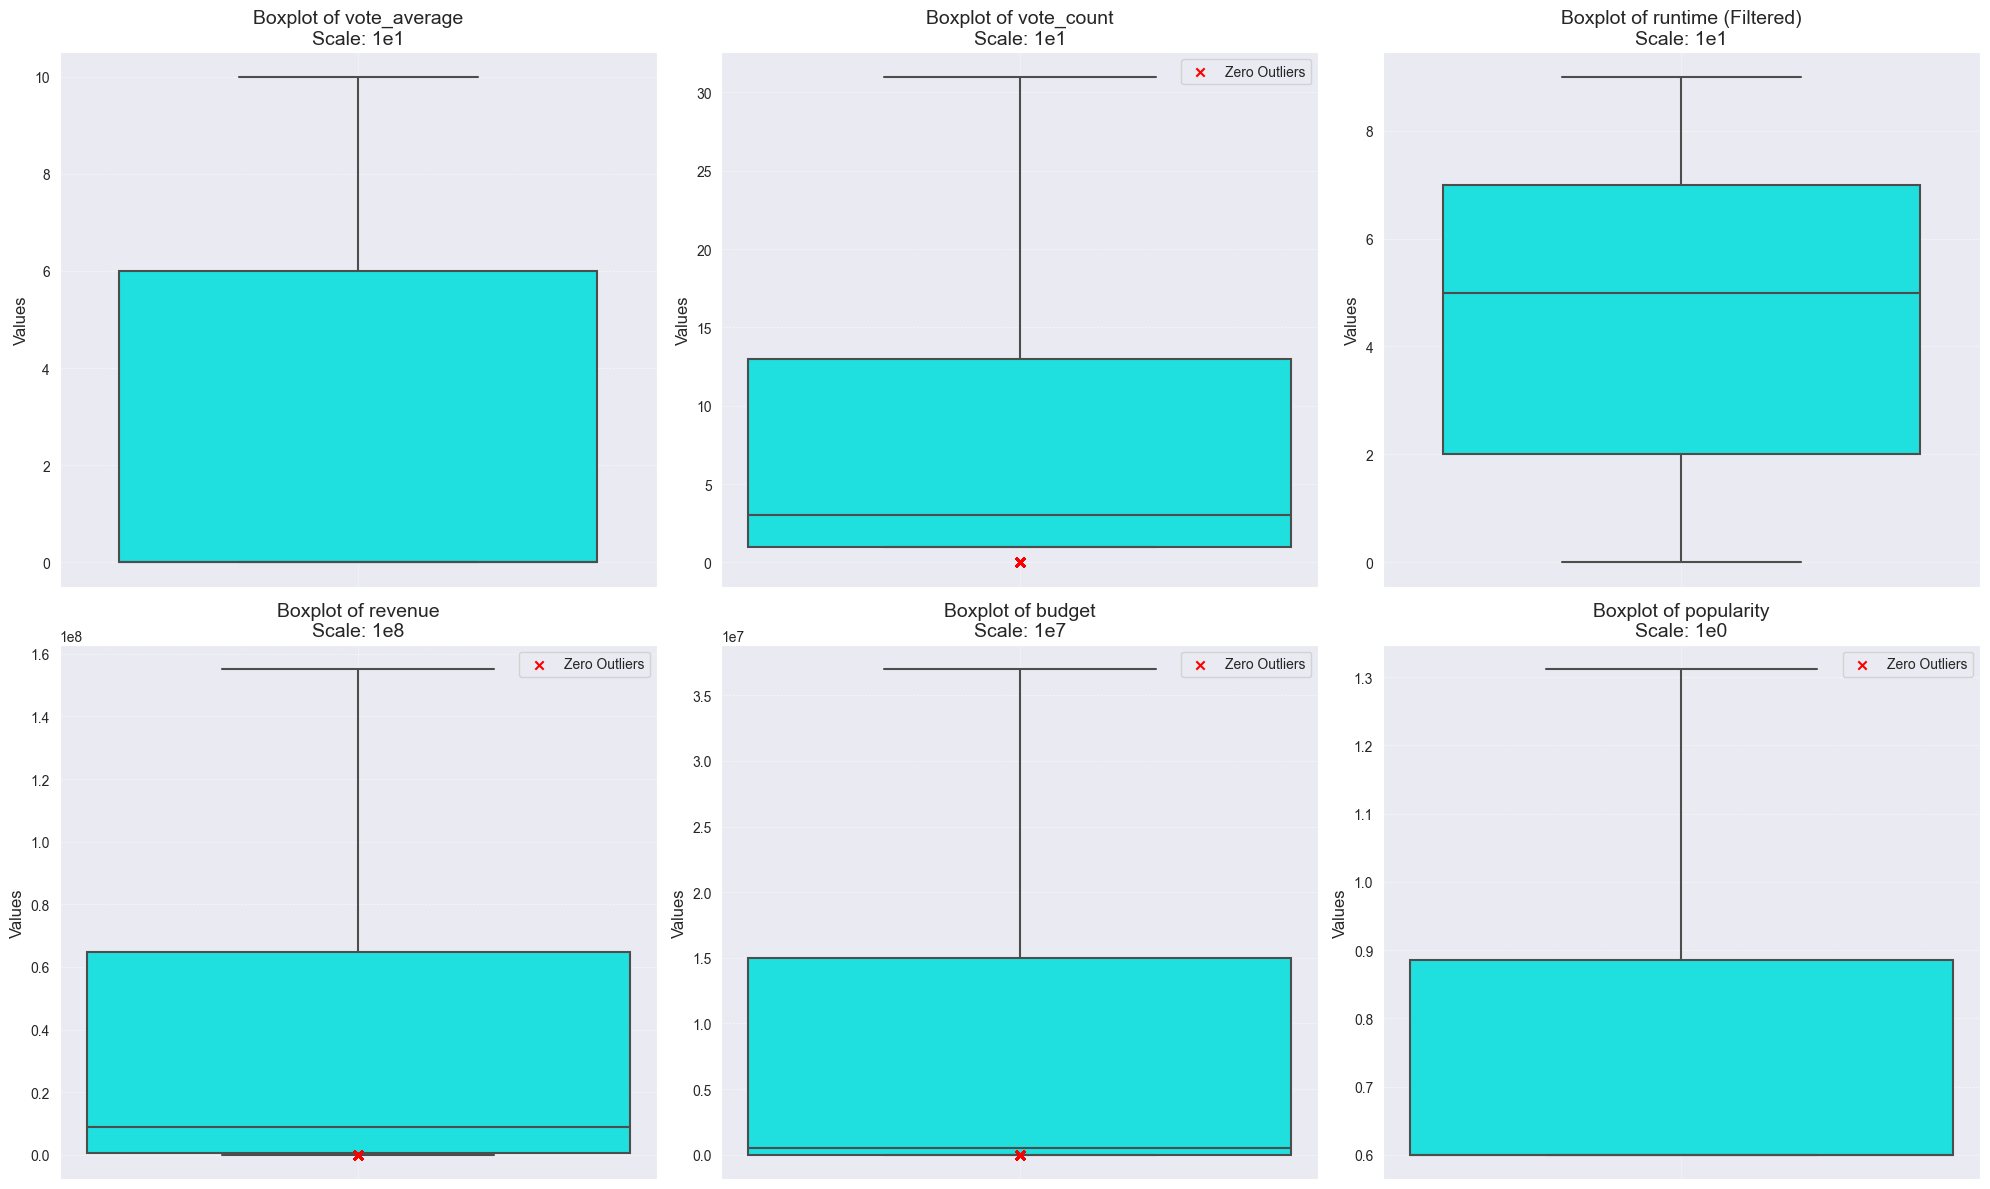

In [244]:
plot_boxplots(df, columns_to_process, exclude_zeros_columns, after_preprocessing=True)

###  Budget and Revenue Scatter plot and association inspection

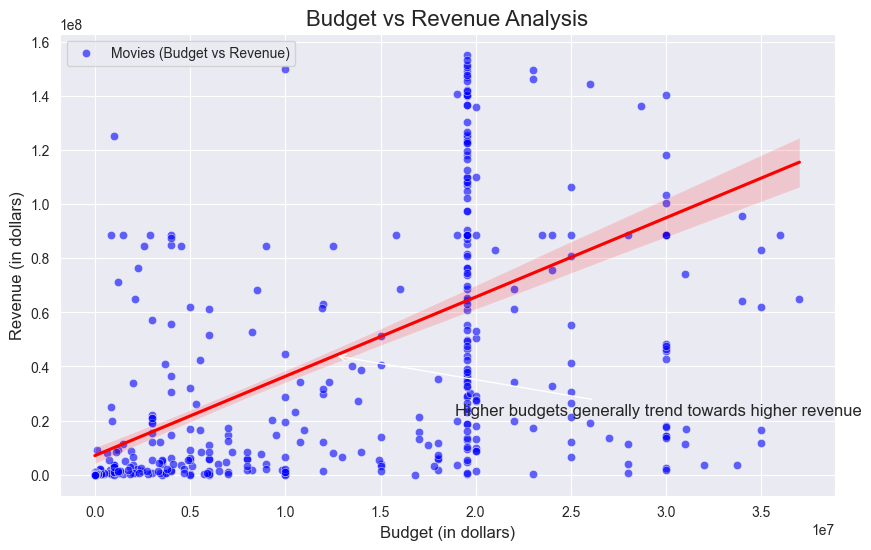

In [245]:
def plot_budget_vs_revenue(data_frame):
    # Filter data to remove rows with non-positive budget or revenue
    filtered_df = data_frame[(data_frame['budget'] > 0) & (data_frame['revenue'] > 0)]

    # Create the scatter plot with appropriate labels and legend
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='budget', y='revenue', data=filtered_df, alpha=0.6, color='blue', label='Movies (Budget vs Revenue)')
    sns.regplot(x='budget', y='revenue', data=filtered_df, scatter=False, color='red', line_kws={"label": "Trend Line"})

    # Add title and axis labels
    plt.title('Budget vs Revenue Analysis', fontsize=16)
    plt.xlabel('Budget (in dollars)', fontsize=12)
    plt.ylabel('Revenue (in dollars)', fontsize=12)

    # Add a legend that describes each plot component
    plt.legend(loc='upper left')
    # Annotate the plot with insights
    plt.annotate('Higher budgets generally trend towards higher revenue', 
                 xy=(filtered_df['budget'].mean(), filtered_df['revenue'].mean()), 
                 xytext=(filtered_df['budget'].mean() * 1.5, filtered_df['revenue'].mean() * 0.5), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
    # Display grid for better visualization
    plt.grid(True)

    # Show the plot
    plt.show()

# Example usage
plot_budget_vs_revenue(df)

### vote_average and vote_count  histogram inspection

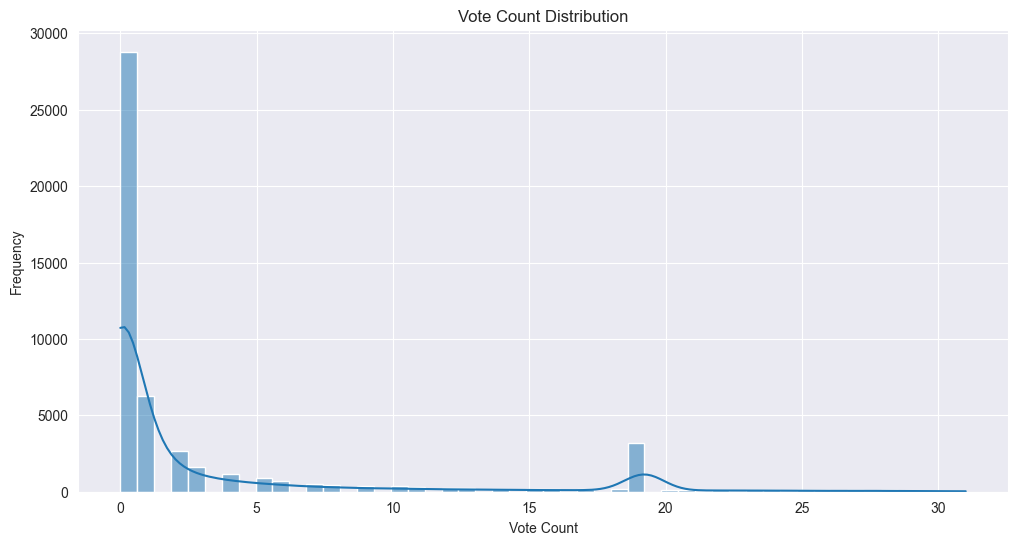

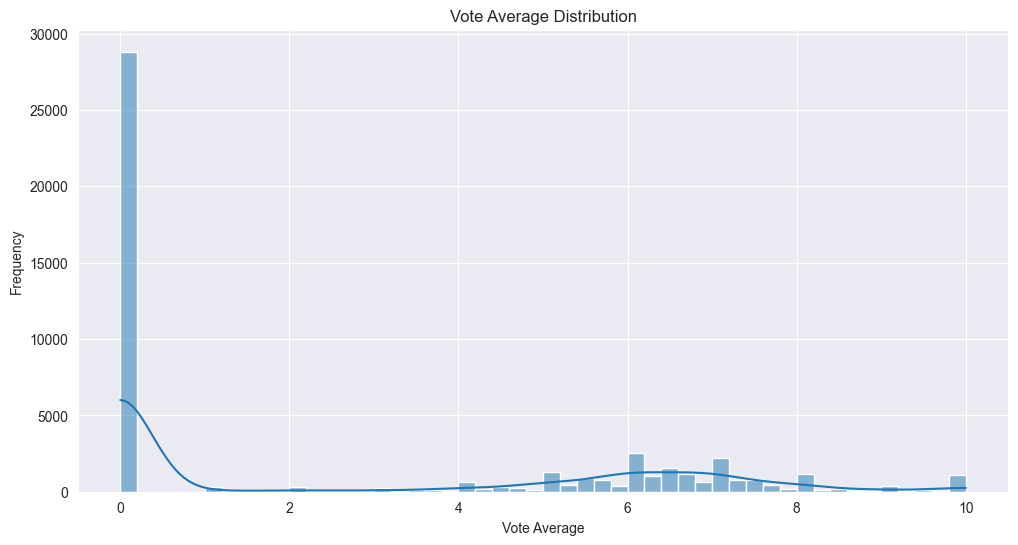

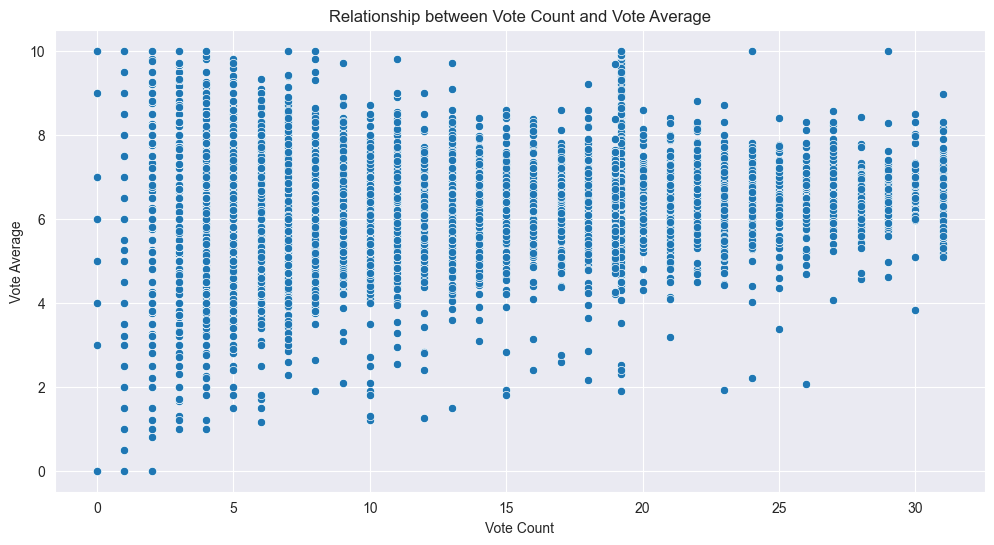

C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\2103949623.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_frame.groupby('vote_count_bins')['vote_average'].mean().reset_index()


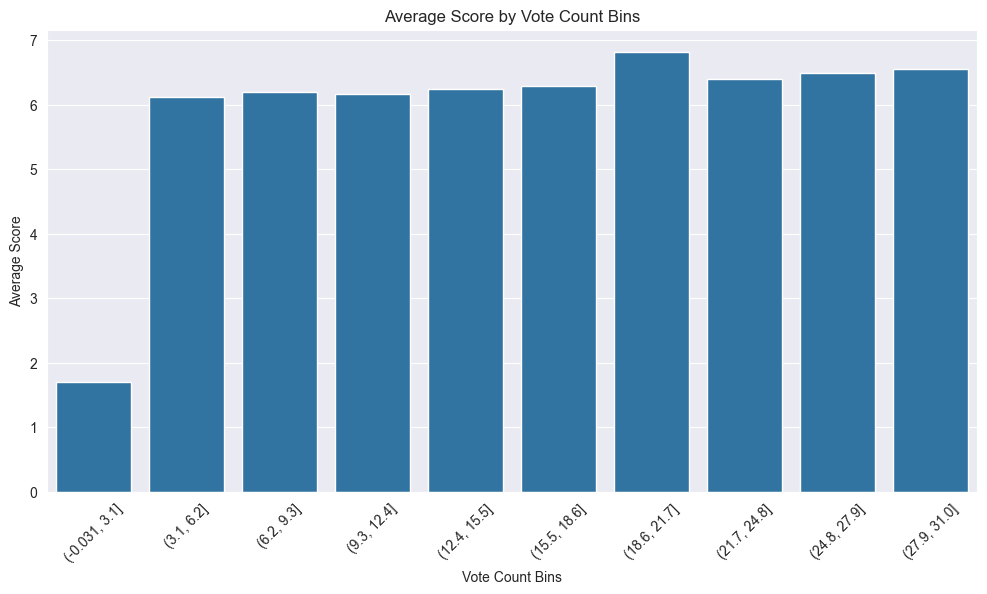

In [246]:
def analyze_votes(data_frame):
    # Plotting vote count distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data_frame['vote_count'], bins=50, kde=True)
    plt.title('Vote Count Distribution')
    plt.xlabel('Vote Count')
    plt.ylabel('Frequency')
    plt.show()

    # Plotting vote average distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data_frame['vote_average'], bins=50, kde=True)
    plt.title('Vote Average Distribution')
    plt.xlabel('Vote Average')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter plot to check the relationship between vote count and vote average
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='vote_count', y='vote_average', data=data_frame)
    plt.title('Relationship between Vote Count and Vote Average')
    plt.xlabel('Vote Count')
    plt.ylabel('Vote Average')
    plt.show()

    # Create bins for vote count
    data_frame['vote_count_bins'] = pd.cut(data_frame['vote_count'], bins=10)

    # Calculate the mean vote average for each bin
    grouped = data_frame.groupby('vote_count_bins')['vote_average'].mean().reset_index()

    # Plotting the binned vote count vs. average score
    plt.figure(figsize=(12, 6))
    sns.barplot(x='vote_count_bins', y='vote_average', data=grouped)
    plt.title('Average Score by Vote Count Bins')
    plt.xlabel('Vote Count Bins')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.show()

# Usage example:
# df = pd.read_csv('movies.csv')
analyze_votes(df)


### Analyzing the Release Trends of Animated Movies Over the Years

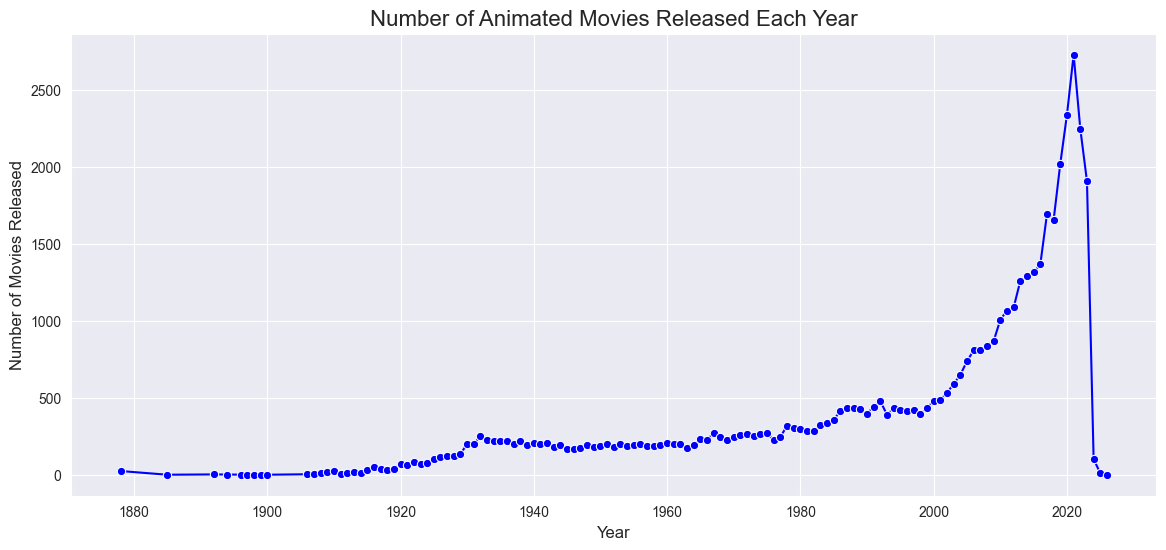

In [247]:
def plot_release_trends(data_frame):
    # Convert the 'release_date' column to datetime format
    data_frame['release_date'] = pd.to_datetime(data_frame['release_date'], errors='coerce')

    # Extract the release year from the 'release_date' column
    data_frame['release_year'] = data_frame['release_date'].dt.year

    # Group by 'release_year' and count the number of movies released each year
    release_counts = data_frame.groupby('release_year').size()

    # Remove rows where 'release_year' is NaN (e.g., missing dates)
    release_counts = release_counts[release_counts.index.notna()]

    # Plot the release trends
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=release_counts.index, y=release_counts.values, marker='o', color='blue')

    # Add titles and labels
    plt.title('Number of Animated Movies Released Each Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Movies Released', fontsize=12)

    # Display the plot
    plt.grid(True)
    plt.show()

# Example usage
plot_release_trends(df)


C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\496668442.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="Blues_d")
C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\496668442.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_vote_avg.index, y=genre_vote_avg.values, palette="Reds_d")
C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\496668442.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_revenue_avg.index, y=genre_revenue_avg.values, palette="Greens_d")

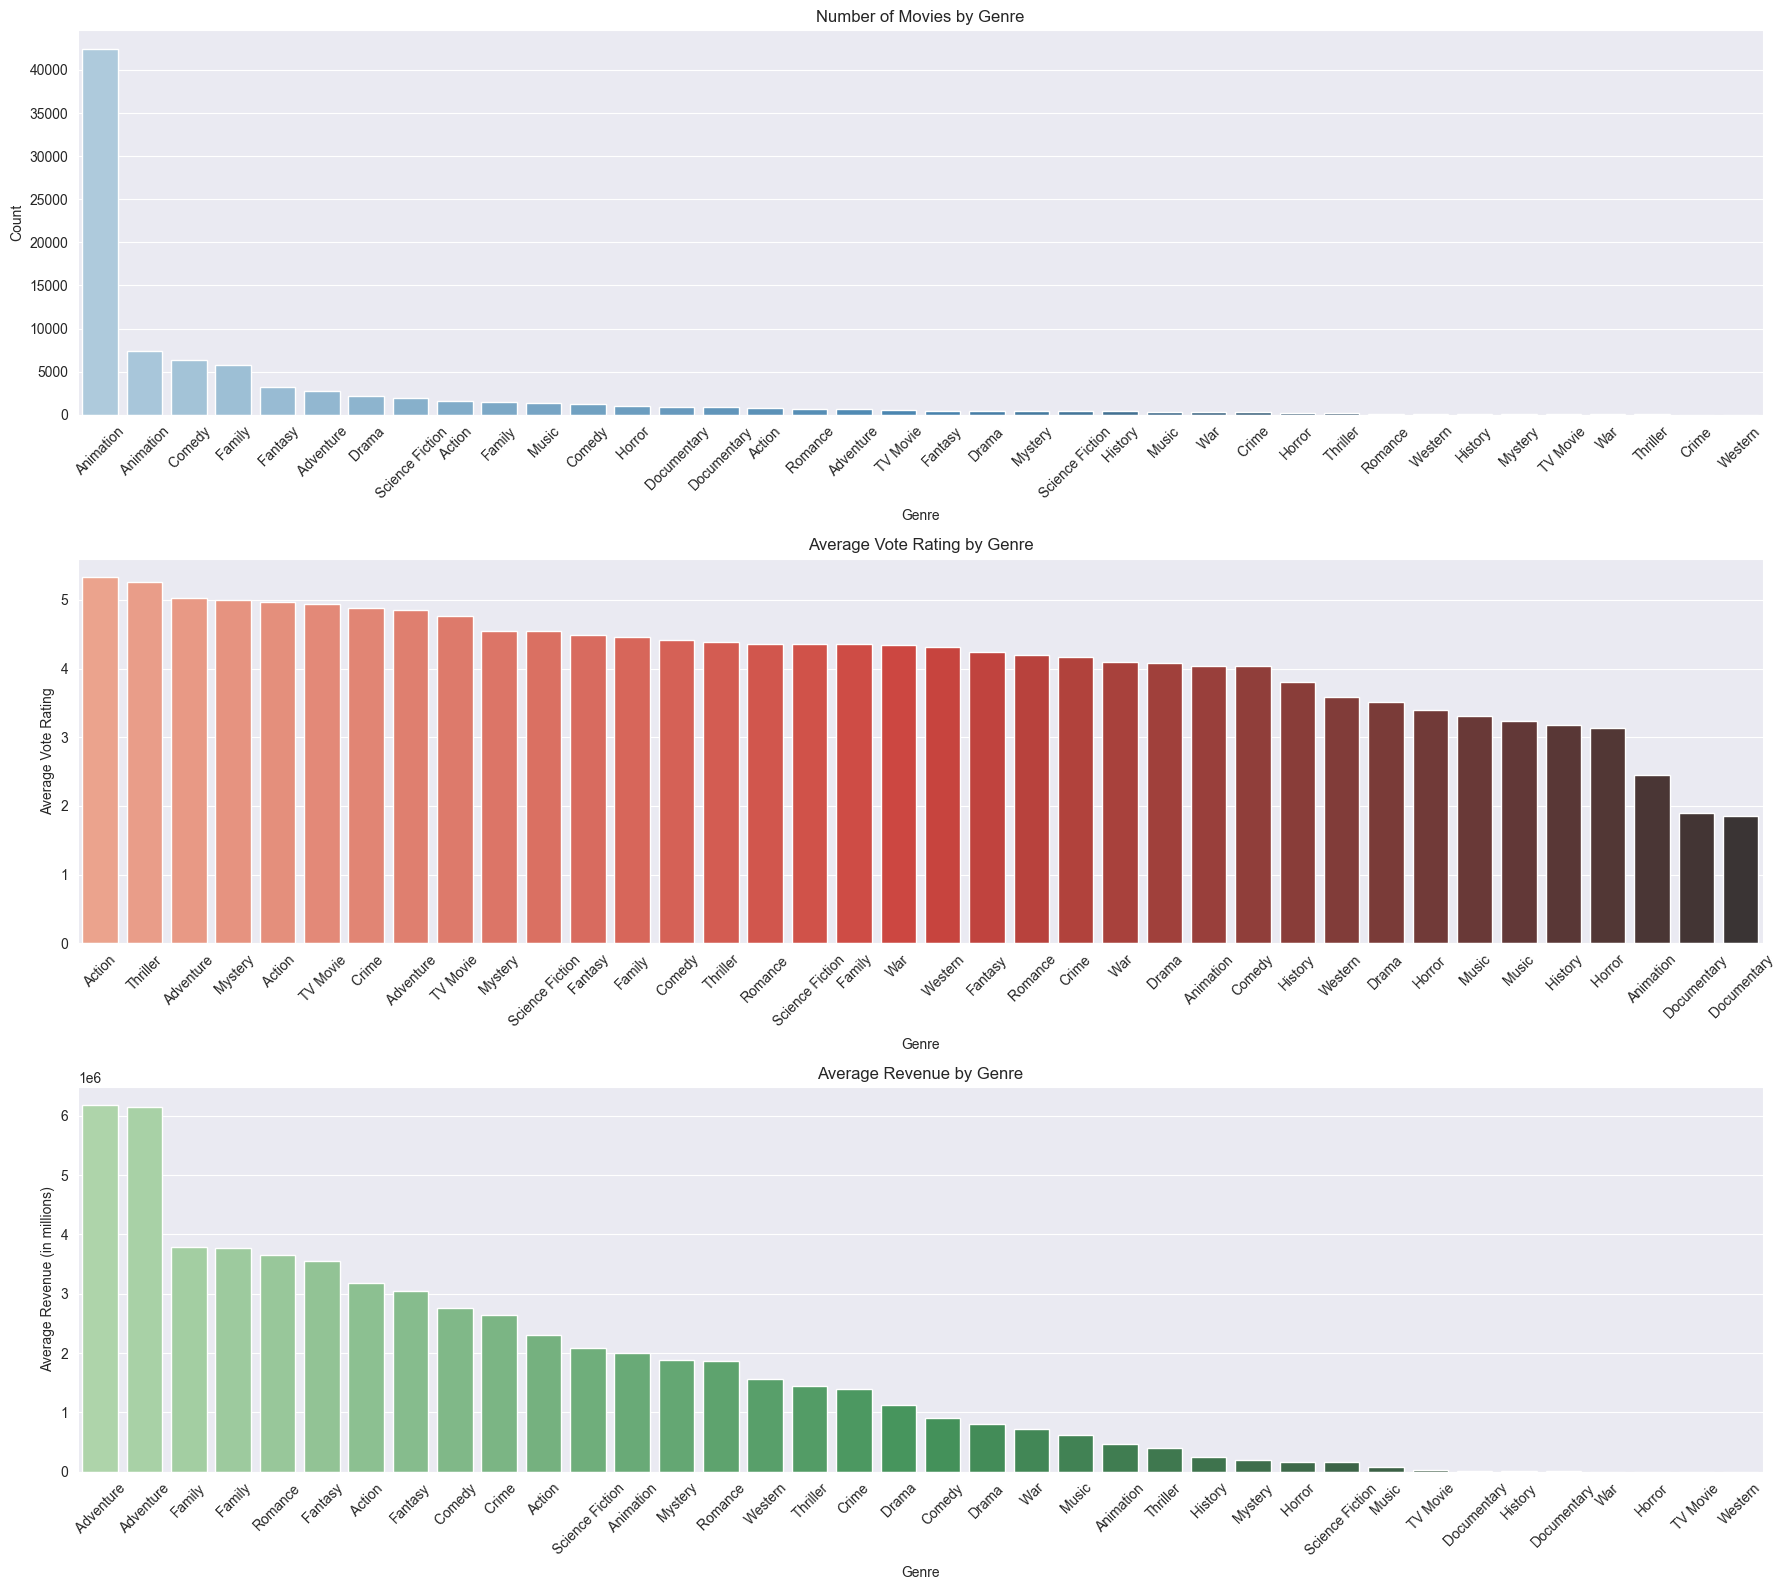

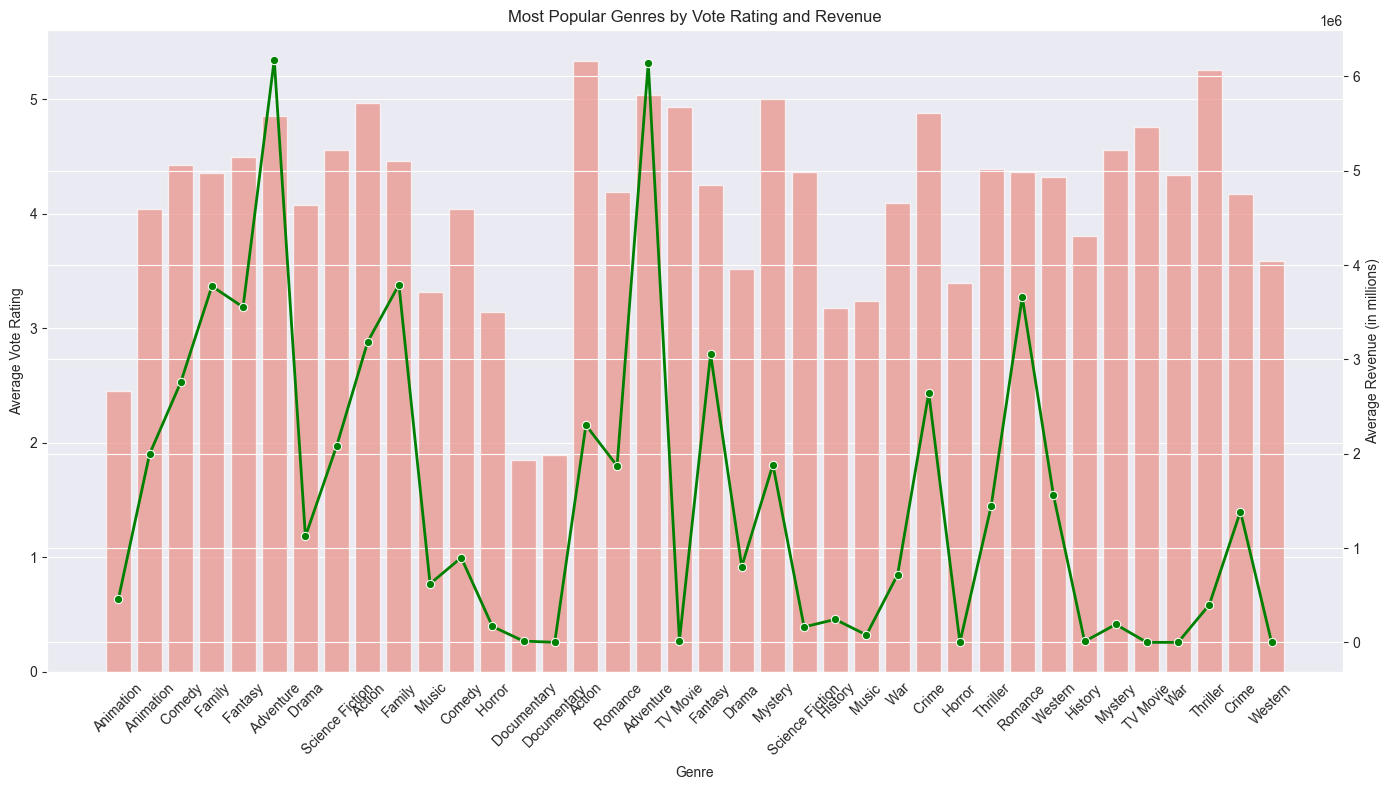

                  Number of Movies  Average Vote Rating  Average Revenue
Animation                    42470             2.449319     4.606510e+05
 Animation                    7345             4.038978     1.996140e+06
 Comedy                       6383             4.421493     2.757127e+06
 Family                       5738             4.355888     3.775964e+06
 Fantasy                      3233             4.490858     3.554726e+06
 Adventure                    2712             4.850590     6.179081e+06
 Drama                        2220             4.075476     1.123640e+06
 Science Fiction              2005             4.552090     2.080109e+06
 Action                       1579             4.964004     3.188093e+06
Family                        1437             4.461095     3.792201e+06
 Music                        1318             3.311615     6.213804e+05
Comedy                        1220             4.036484     8.985562e+05
 Horror                       1057             3.13

In [248]:
def analyze_genres(data_frame):
    # 1. Count the number of movies in each genre
    genre_counts = data_frame['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
    
    # 2. Calculate the average vote rating (vote_average) for each genre
    genre_vote_avg = data_frame['genres'].str.get_dummies(sep=',').multiply(data_frame['vote_average'], axis=0).sum() / genre_counts
    genre_vote_avg = genre_vote_avg.sort_values(ascending=False)

    # 3. Calculate the average revenue for each genre
    genre_revenue_avg = data_frame['genres'].str.get_dummies(sep=',').multiply(data_frame['revenue'], axis=0).sum() / genre_counts
    genre_revenue_avg = genre_revenue_avg.sort_values(ascending=False)
    
    # Set up the figure for subplots
    plt.figure(figsize=(18, 16))
    
    # Plot number of movies by genre
    plt.subplot(3, 1, 1)
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="Blues_d")
    plt.title('Number of Movies by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot average vote rating by genre
    plt.subplot(3, 1, 2)
    sns.barplot(x=genre_vote_avg.index, y=genre_vote_avg.values, palette="Reds_d")
    plt.title('Average Vote Rating by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Vote Rating')
    plt.xticks(rotation=45)

    # Plot average revenue by genre
    plt.subplot(3, 1, 3)
    sns.barplot(x=genre_revenue_avg.index, y=genre_revenue_avg.values, palette="Greens_d")
    plt.title('Average Revenue by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Average Revenue (in millions)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def analyze_genre_popularity(data_frame):
    # Count the number of movies in each genre
    genre_counts = data_frame['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
    
    # Calculate the average vote rating for each genre
    genre_vote_avg = data_frame['genres'].str.get_dummies(sep=',').multiply(data_frame['vote_average'], axis=0).sum() / genre_counts
    
    # Calculate the average revenue for each genre
    genre_revenue_avg = data_frame['genres'].str.get_dummies(sep=',').multiply(data_frame['revenue'], axis=0).sum() / genre_counts

    # Create a DataFrame for final analysis
    genre_analysis_df = pd.DataFrame({
        'Number of Movies': genre_counts,
        'Average Vote Rating': genre_vote_avg,
        'Average Revenue': genre_revenue_avg
    }).sort_values(by='Number of Movies', ascending=False)
    
    # Plot the combined analysis table with dual y-axis
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot Average Vote Rating on the primary y-axis
    sns.barplot(x=genre_analysis_df.index, y='Average Vote Rating', data=genre_analysis_df, ax=ax1, color='salmon', alpha=0.7)
    ax1.set_xlabel("Genre")
    ax1.set_ylabel("Average Vote Rating")
    ax1.set_title("Most Popular Genres by Vote Rating and Revenue")
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot Average Revenue on the secondary y-axis
    ax2 = ax1.twinx()
    sns.lineplot(x=genre_analysis_df.index, y='Average Revenue', data=genre_analysis_df, ax=ax2, color='green', marker='o', linewidth=2)
    ax2.set_ylabel("Average Revenue (in millions)")
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Display the analysis table
    print(genre_analysis_df)

analyze_genres(df)

analyze_genre_popularity(df)

In [249]:
df.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date',
       'revenue', 'runtime', 'adult', 'budget', 'original_language',
       'original_title', 'overview', 'popularity', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'Year', 'processed_overview', 'original_language_encoded',
       'production_companies_encoded', 'production_countries_encoded',
       'spoken_languages_encoded', 'status_encoded', 'adult_encoded',
       'budget_category', 'revenue_category', 'popularity_category',
       'runtime_category', 'vote_average_category', 'release_decade', 'ROI',
       'release_month', 'release_season', 'success_metric',
       'genre_similarity_score', 'content_complexity', 'popularity_normalized',
       'runtime_normalized', 'vote_average_normalized', 'budget_normalized',
       'revenue_normalized', 'vote_count_normalized', 'Year_normalized',
       'vote_count_bins', 'release_year'],
      dtype='object')

### "Analysis of Top Production Companies by High-Rating Movies: Popularity, Average Vote, and Revenue Insights"

C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\1082998976.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=company_analysis_df.index, y='High-Rating Movie Count', data=company_analysis_df, ax=ax[0], palette="viridis")


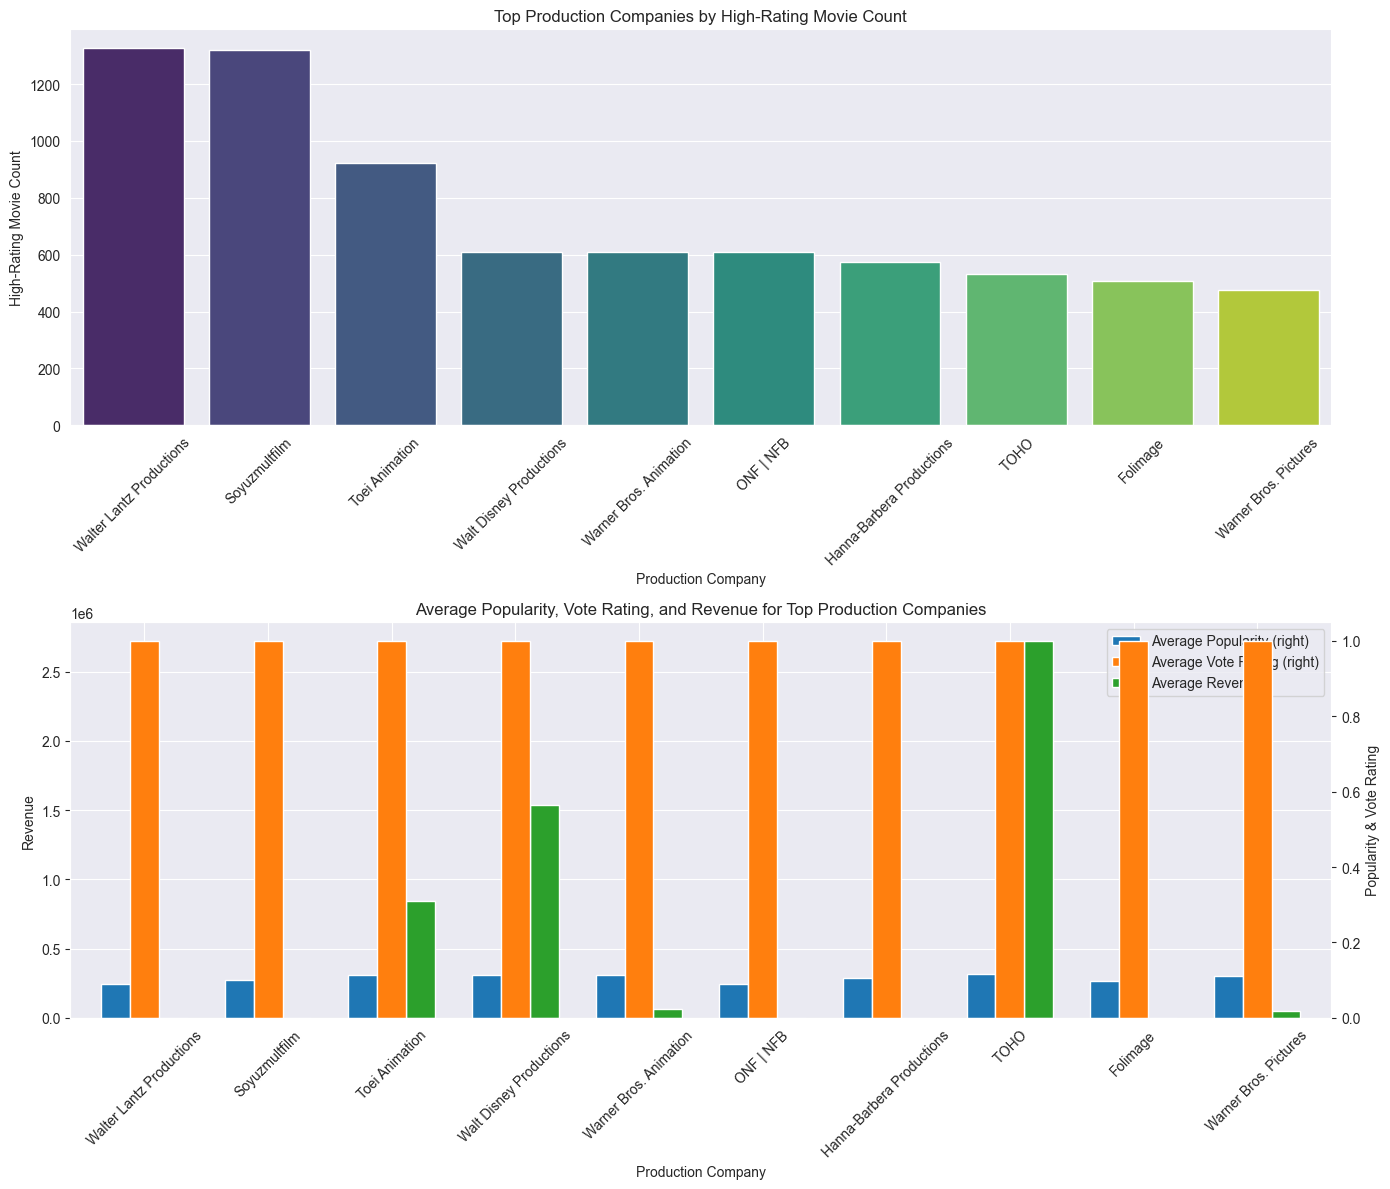

                           High-Rating Movie Count  Average Popularity  \
Walter Lantz Productions                  1325.900            0.091027   
Soyuzmultfilm                             1320.338            0.099188   
Toei Animation                             920.722            0.113901   
Walt Disney Productions                    611.093            0.113956   
Warner Bros. Animation                     610.109            0.112665   
ONF | NFB                                  609.904            0.088788   
Hanna-Barbera Productions                  576.086            0.105022   
 TOHO                                      533.869            0.115447   
Folimage                                   506.227            0.097028   
Warner Bros. Pictures                      474.855            0.111823   

                           Average Vote Rating  Average Revenue  
Walter Lantz Productions                   1.0     0.000000e+00  
Soyuzmultfilm                              1.0     3.

In [250]:
def analyze_production_companies(data_frame):
    # Define high rating threshold (e.g., vote_average above 7)
    high_rating_threshold = 7
    
    # Filter movies with high vote average
    high_rating_movies = data_frame[data_frame['vote_average'] >= high_rating_threshold]
    
    # Split and expand production_companies into individual rows
    companies = high_rating_movies['production_companies'].str.get_dummies(sep=',').multiply(high_rating_movies['vote_average'], axis=0)
    
    # Calculate the count of high-rating movies by each company
    company_movie_counts = companies.sum().sort_values(ascending=False)
    
    # Calculate the mean popularity, vote_average, and revenue for high-rating movies by each company
    company_popularity_avg = high_rating_movies['production_companies'].str.get_dummies(sep=',').multiply(high_rating_movies['popularity'], axis=0).sum() / company_movie_counts
    company_vote_avg = companies.sum() / company_movie_counts
    company_revenue_avg = high_rating_movies['production_companies'].str.get_dummies(sep=',').multiply(high_rating_movies['revenue'], axis=0).sum() / company_movie_counts
    
    # Create a DataFrame to store the final analysis
    company_analysis_df = pd.DataFrame({
        'High-Rating Movie Count': company_movie_counts,
        'Average Popularity': company_popularity_avg,
        'Average Vote Rating': company_vote_avg,
        'Average Revenue': company_revenue_avg
    }).sort_values(by='High-Rating Movie Count', ascending=False)
    
    # Remove 'null' company row if exists
    company_analysis_df = company_analysis_df[company_analysis_df.index != 'null'].head(10)  # Top 10 companies excluding 'null'
    
    # Plot the analysis results
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))
    
    # Bar plot for High-Rating Movie Count
    sns.barplot(x=company_analysis_df.index, y='High-Rating Movie Count', data=company_analysis_df, ax=ax[0], palette="viridis")
    ax[0].set_title('Top Production Companies by High-Rating Movie Count')
    ax[0].set_xlabel('Production Company')
    ax[0].set_ylabel('High-Rating Movie Count')
    ax[0].tick_params(axis='x', rotation=45)
    
    # Plot Average Popularity, Vote Rating, and Revenue with a second y-axis for visibility
    company_analysis_df[['Average Popularity', 'Average Vote Rating', 'Average Revenue']].plot(
        kind='bar', ax=ax[1], width=0.7, secondary_y=['Average Popularity', 'Average Vote Rating']
    )
    ax[1].set_title('Average Popularity, Vote Rating, and Revenue for Top Production Companies')
    ax[1].set_xlabel('Production Company')
    ax[1].set_ylabel('Revenue')
    ax[1].right_ax.set_ylabel('Popularity & Vote Rating')
    ax[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Display the analysis table
    print(company_analysis_df)

# Run the analysis function
analyze_production_companies(df)

# XXX

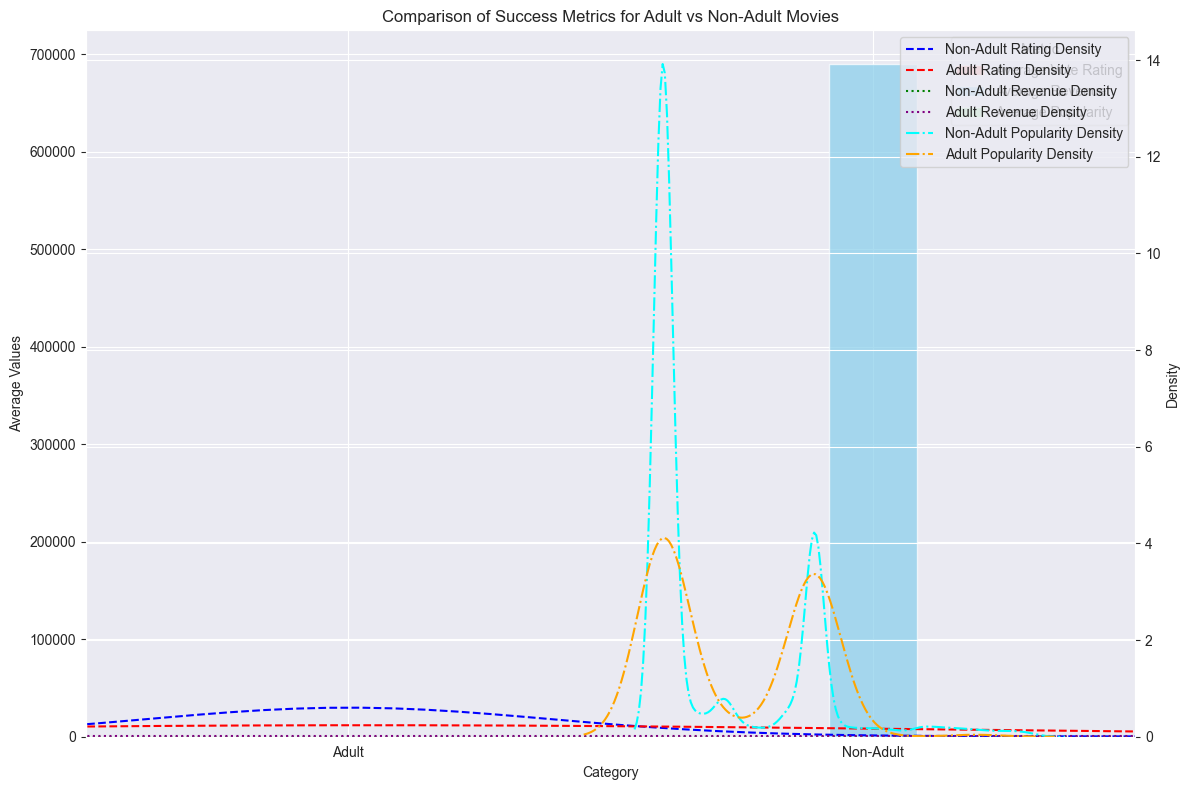

In [251]:
def analyze_adult_movies_combined(data_frame):
    # Filter movies into adult and non-adult categories
    adult_movies = data_frame[data_frame['adult'] == True]
    non_adult_movies = data_frame[data_frame['adult'] == False]

    # Calculate mean values for rating, revenue, and popularity for each category
    adult_stats = {
        'Average Vote Rating': adult_movies['vote_average'].mean(),
        'Average Revenue': adult_movies['revenue'].mean(),
        'Average Popularity': adult_movies['popularity'].mean()
    }
    
    non_adult_stats = {
        'Average Vote Rating': non_adult_movies['vote_average'].mean(),
        'Average Revenue': non_adult_movies['revenue'].mean(),
        'Average Popularity': non_adult_movies['popularity'].mean()
    }

    # Convert statistics into a DataFrame for easier plotting
    stats_df = pd.DataFrame([adult_stats, non_adult_stats], index=['Adult', 'Non-Adult'])
    
    # Combined bar plot for average metrics
    fig, ax1 = plt.subplots(figsize=(12, 8))
    stats_df.plot(kind='bar', ax=ax1, color=['salmon', 'skyblue', 'lightgreen'], alpha=0.7)
    ax1.set_title('Comparison of Success Metrics for Adult vs Non-Adult Movies')
    ax1.set_ylabel('Average Values')
    ax1.set_xlabel('Category')
    ax1.tick_params(axis='x', rotation=0)
    ax1.legend(title='Metric')

    # Overlaying density plots for each metric on the right y-axis
    ax2 = ax1.twinx()
    sns.kdeplot(non_adult_movies['vote_average'], ax=ax2, color='blue', linestyle="--", label='Non-Adult Rating Density')
    sns.kdeplot(adult_movies['vote_average'], ax=ax2, color='red', linestyle="--", label='Adult Rating Density')
    sns.kdeplot(non_adult_movies['revenue'], ax=ax2, color='green', linestyle=":", label='Non-Adult Revenue Density')
    sns.kdeplot(adult_movies['revenue'], ax=ax2, color='purple', linestyle=":", label='Adult Revenue Density')
    sns.kdeplot(non_adult_movies['popularity'], ax=ax2, color='cyan', linestyle="-.", label='Non-Adult Popularity Density')
    sns.kdeplot(adult_movies['popularity'], ax=ax2, color='orange', linestyle="-.", label='Adult Popularity Density')
    
    ax2.set_ylabel('Density')
    ax2.legend(loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
# df = pd.read_csv('movies.csv')
analyze_adult_movies_combined(df)


### XXX

C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\4261489539.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame['ROI'].replace([float('inf'), float('nan')], 0, inplace=True)
C:\Users\Pooria\AppData\Local\Temp\ipykernel_32532\4261489539.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROI', y='title', data=sorted_df, palette="viridis")


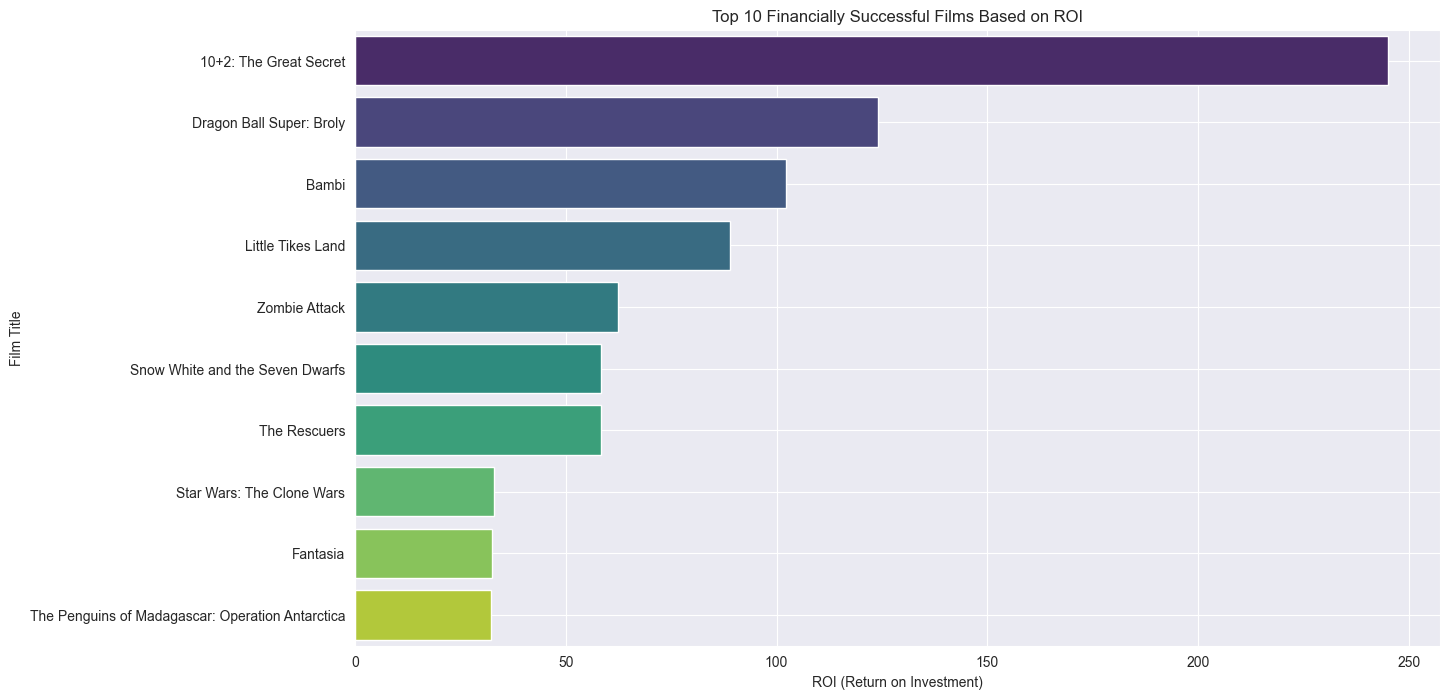

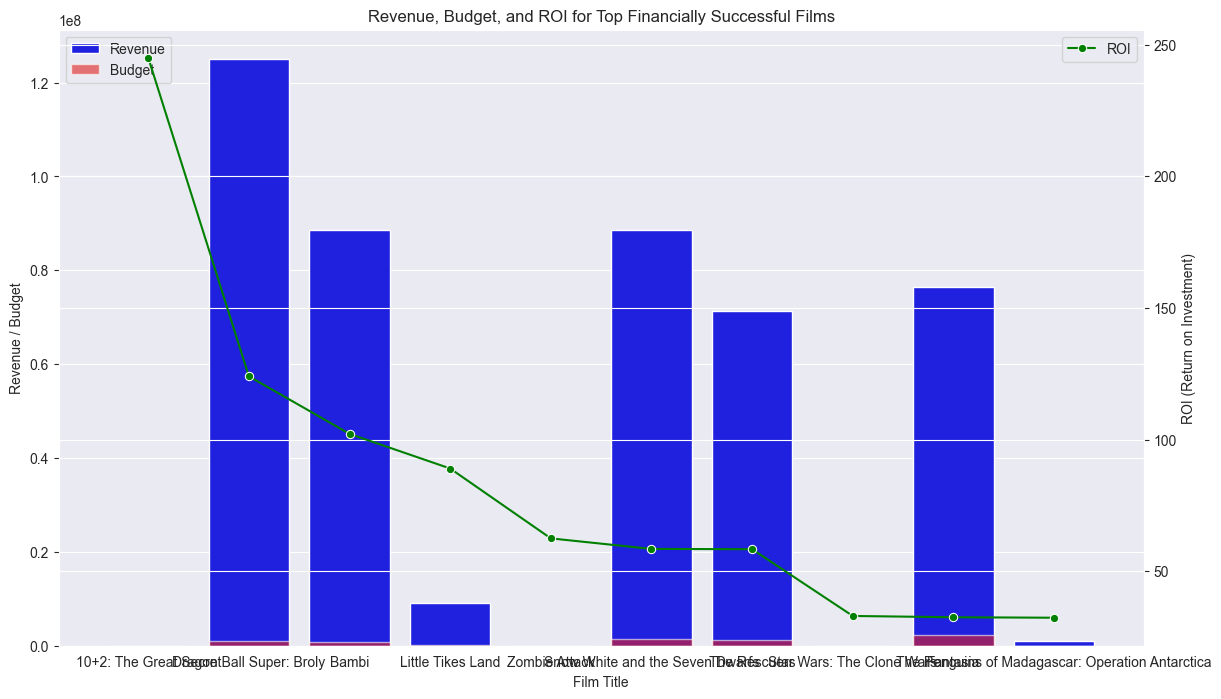

                                                  title     budget  \
39597                            10+2: The Great Secret        1.0   
180                            Dragon Ball Super: Broly  1000000.0   
99                                                Bambi   858000.0   
40362                                 Little Tikes Land   100000.0   
34940                                     Zombie Attack       52.0   
63                      Snow White and the Seven Dwarfs  1488423.0   
202                                        The Rescuers  1200000.0   
20878                         Star Wars: The Clone Wars        2.0   
176                                            Fantasia  2280000.0   
6545   The Penguins of Madagascar: Operation Antarctica    30000.0   

            revenue         ROI  
39597  2.460000e+02  245.000000  
180    1.250028e+08  124.002821  
99     8.850803e+07  102.156215  
40362  9.000000e+06   89.000000  
34940  3.300000e+03   62.461538  
63     8.850803e+07   58.

In [252]:
def analyze_financial_success(data_frame):
    # Calculate the ROI
    data_frame['ROI'] = (data_frame['revenue'] - data_frame['budget']) / data_frame['budget']
    
    # Replace inf and NaN values with zero (if the budget is zero, it could lead to inf values)
    data_frame['ROI'].replace([float('inf'), float('nan')], 0, inplace=True)
    
    # Filter out movies with zero budget to avoid skewed ratios
    data_frame = data_frame[data_frame['budget'] > 0]
    
    # Sort the DataFrame by the ROI in descending order
    sorted_df = data_frame.sort_values(by='ROI', ascending=False).head(10)
    
    # Plot the top 10 financially successful films based on ROI
    plt.figure(figsize=(14, 8))
    sns.barplot(x='ROI', y='title', data=sorted_df, palette="viridis")
    plt.title('Top 10 Financially Successful Films Based on ROI')
    plt.xlabel('ROI (Return on Investment)')
    plt.ylabel('Film Title')
    plt.grid(True)
    plt.show()

    # Plot combined chart of revenue, budget, and ROI
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot revenue and budget
    sns.barplot(x='title', y='revenue', data=sorted_df, ax=ax1, color='blue', label='Revenue')
    sns.barplot(x='title', y='budget', data=sorted_df, ax=ax1, color='red', label='Budget', alpha=0.6)

    # Create a second y-axis for ROI
    ax2 = ax1.twinx()
    sns.lineplot(x='title', y='ROI', data=sorted_df, ax=ax2, color='green', label='ROI', marker='o')
    
    # Add titles and labels
    ax1.set_title('Revenue, Budget, and ROI for Top Financially Successful Films')
    ax1.set_xlabel('Film Title')
    ax1.set_ylabel('Revenue / Budget')
    ax2.set_ylabel('ROI (Return on Investment)')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
    
    # Display the analysis table
    print(sorted_df[['title', 'budget', 'revenue', 'ROI']])


analyze_financial_success(df)


Languages with less than 1% representation:
               Language  Percentage (%)
                 Polish        0.939778
                English        0.895666
                  Czech        0.843882
                 Korean        0.740315
                Italian        0.665516
                Swedish        0.634829
              Ukrainian        0.565784
                 French        0.552359
                Spanish        0.446874
                 Danish        0.439202
              Hungarian        0.431530
               Japanese        0.352896
                  Dutch        0.337553
               Estonian        0.299194
                Italian        0.270426
                 German        0.268508
                Finnish        0.264672
              Norwegian        0.258918
             Portuguese        0.230150
                Tagalog        0.216724
                  Hindi        0.214806
                Russian        0.197545
                 Arabic        0.180

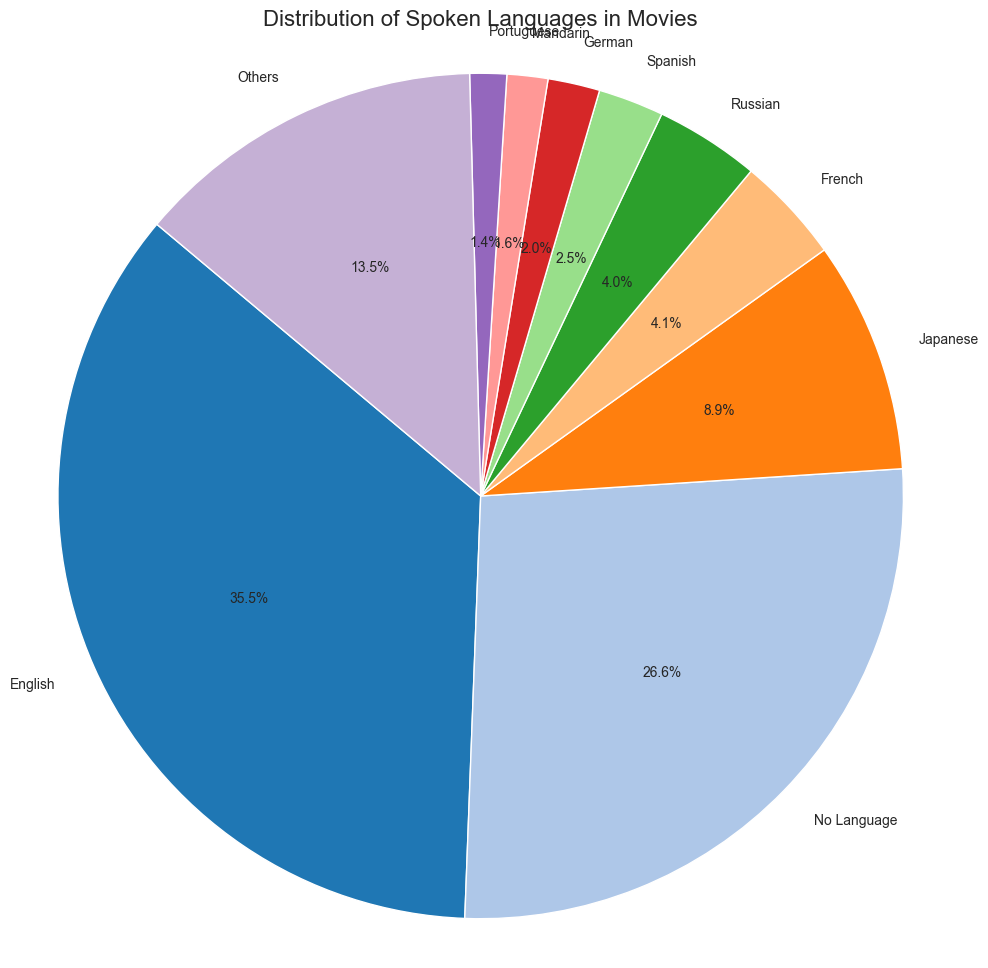

In [253]:


def plot_language_distribution(data_frame):
    # Replace NaN values and 'null' values with "No Language"
    # data_frame['spoken_languages'] = data_frame['spoken_languages'].replace('null', 'No Language')
    
    # Split the 'spoken_languages' column into individual languages
    language_data = data_frame['spoken_languages'].str.get_dummies(sep=',')
    
    # Sum the occurrences of each language to count how many movies feature that language
    language_counts = language_data.sum().sort_values(ascending=False)
    
    # Select the top languages to avoid a cluttered pie chart
    top_languages = language_counts[language_counts / language_counts.sum() >= 0.01]  # Display languages > 1%
    other_languages_count = language_counts[language_counts / language_counts.sum() < 0.01].sum()
    
    # Append "Others" category for remaining languages
    top_languages['Others'] = other_languages_count

    # Plot the pie chart
    plt.figure(figsize=(12, 12))
    plt.pie(top_languages, labels=top_languages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    plt.title('Distribution of Spoken Languages in Movies', fontsize=16)
    plt.axis('equal')  # Ensure pie chart is a circle
    
    # Display the table for languages with less than 1%
    small_percent_table = pd.DataFrame({
        'Language': [lang for lang, perc in zip(language_counts.index, language_counts / language_counts.sum() * 100) if perc < 1],
        'Percentage (%)': [perc for perc in language_counts / language_counts.sum() * 100 if perc < 1]
    })

    # Print the table for languages with less than 1%
    if not small_percent_table.empty:
        print("Languages with less than 1% representation:")
        print(small_percent_table.to_string(index=False))

    # Display the plot
    plt.show()

# Example usage
plot_language_distribution(df)
